In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import Dataset, DataLoader
import pickle
from script.util import create_graph, subgraph_dijkstra, LSTMModel, TimeSeriesDataset, my_data_loader,ExpSmooth
from src.fedutil import local_dataset, fed_training_plan
import matplotlib.pyplot as plt
import networkx as nx
from script.metrics import rmse, rmspe, maape, rmsse
from sklearn.metrics import mean_absolute_error


In [75]:
flow_file= "./data/PEMS04/pems04.npz"
csv_file = "./data/PEMS04/distance.csv"

data = np.load(flow_file)
df = pd.read_csv(csv_file)
TS = data['data']
flow = TS[:,:,0]

# flow dict 100 time series is the sensor number and the value the traffic flow times serie
flow_dict={k:flow[:,k] for k in range(307)}

# list of the first 10 connected sensor, each sensor traffic flow is contained in PeMS 
PeMS = pd.DataFrame(flow_dict)
# time serie of sensor k
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)
PeMS = PeMS.set_index(index)
maximum = PeMS.max().max()

In [38]:
PeMS = PeMS[-4000:]

In [76]:
G = create_graph(df)

In [77]:
subgraph = subgraph_dijkstra(G,0,99)

In [84]:
PeMS = PeMS[list(subgraph.nodes)]

#Sort time series by mean traffic flow
mean_flow = PeMS.mean().sort_values()
#Index of sensor sort by mean traffic flow
mean_flow_index = mean_flow.index


column_order = list(mean_flow_index)
PeMS =PeMS.reindex(columns=column_order)

In [63]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:47] + column_order[48:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 170, 169, 168]


In [64]:
for i in goodnodes:
    print("Nodes {} with mean traffic flow : {}".format(i,mean_flow[i]))

Nodes 118 with mean traffic flow : 236.87270480225988
Nodes 261 with mean traffic flow : 240.57203389830508
Nodes 179 with mean traffic flow : 240.57203389830508
Nodes 170 with mean traffic flow : 240.57203389830508
Nodes 169 with mean traffic flow : 240.57203389830508
Nodes 168 with mean traffic flow : 242.85905131826743


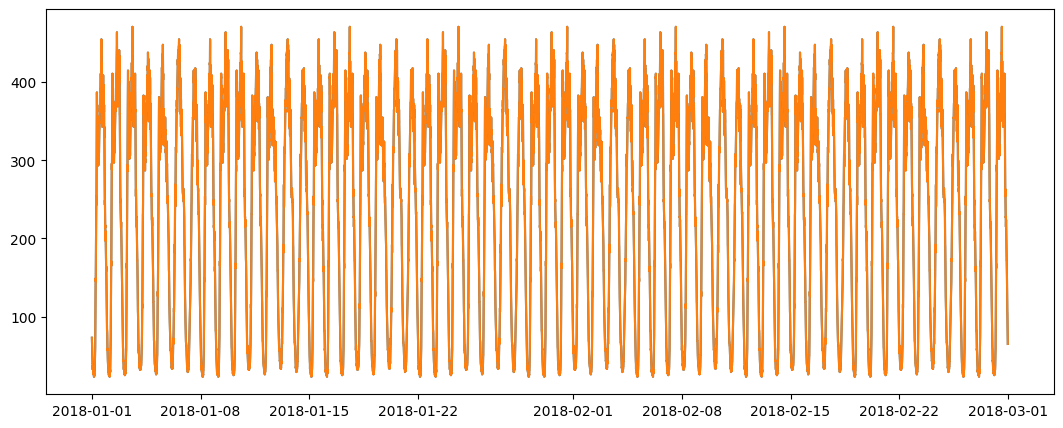

In [65]:
plt.figure(figsize=(13, 5))
plt.plot(PeMS[261])
plt.plot(PeMS[169])

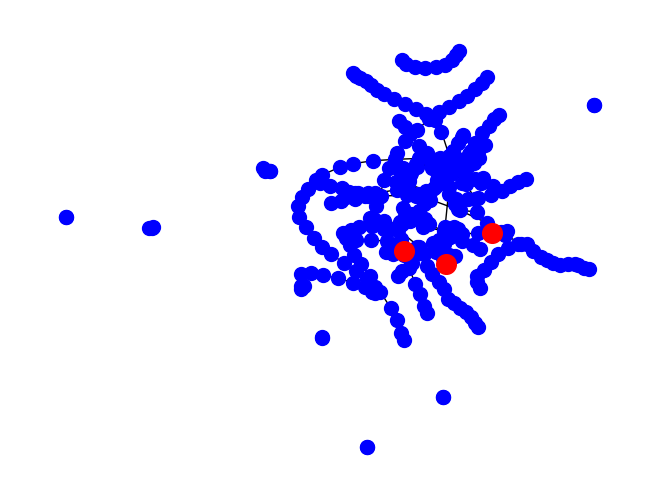

In [81]:
import networkx as nx
import matplotlib.pyplot as plt


pos = nx.spring_layout(G)

nx.draw(G, pos=pos, node_color='b', node_size=100)
nx.draw_networkx_nodes(G, pos=pos, nodelist=[118,168,261], node_color='r', node_size=200)

plt.show()

In [68]:
duplicate=PeMS.T.duplicated()

In [69]:
print(PeMS.columns[duplicate])

Index([181, 179, 177, 170, 169], dtype='int64')


In [70]:
print("Nodes which are better in multivariate" )
goodnodes = column_order[44:51]
print(goodnodes)

Nodes which are better in multivariate
[118, 261, 179, 177, 170, 169, 168]


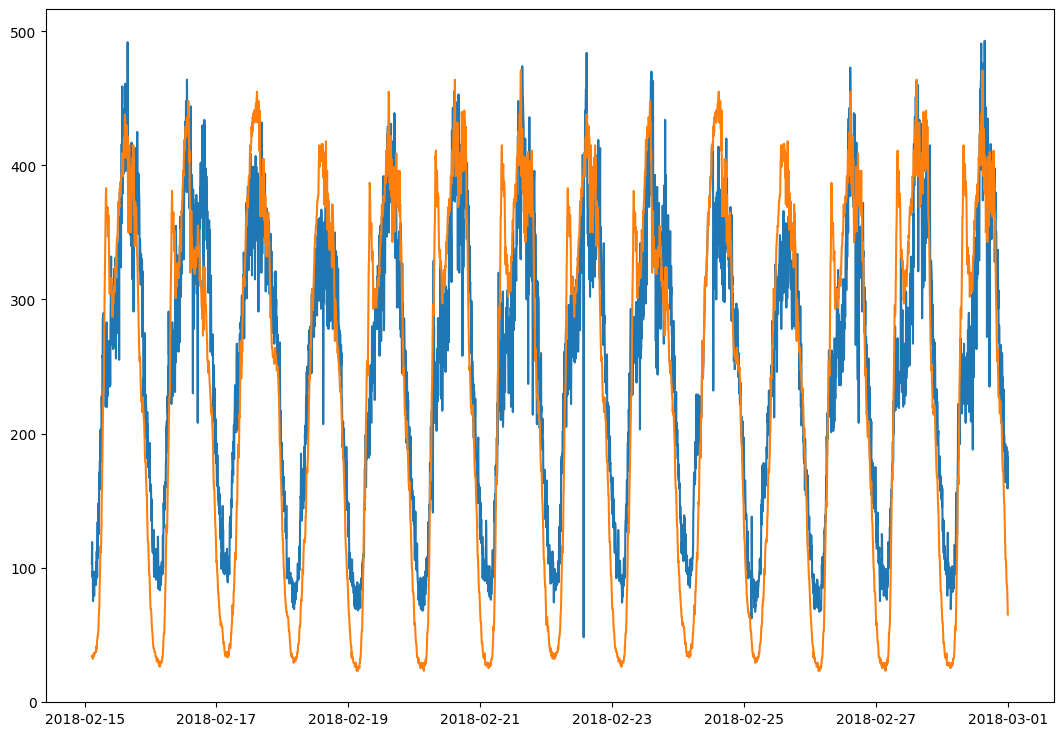

In [40]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[168])
plt.plot(PeMS[261])

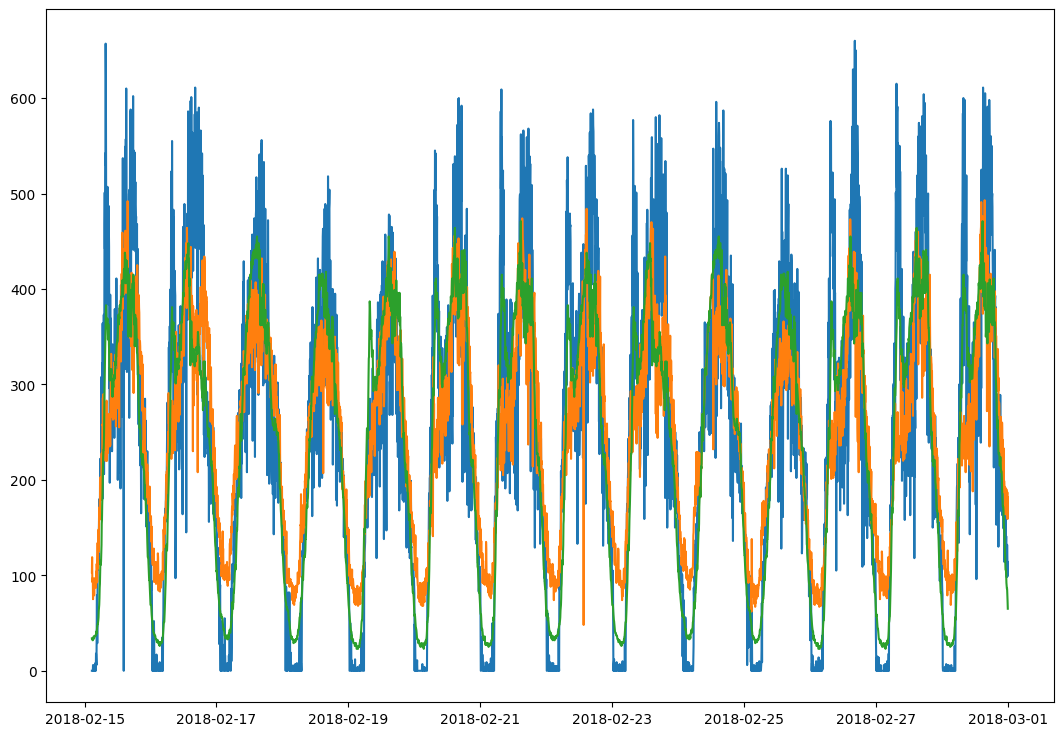

In [41]:
plt.figure(figsize = (13,9))
plt.plot(PeMS[118])
plt.plot(PeMS[168])
plt.plot(PeMS[261])

In [42]:
fedPeMS = PeMS[[118,168,261]]

In [43]:
# Smoot DataFrame
df = ExpSmooth(fedPeMS,3)

c:\Users\mbenali\Desktop\Federated-Traffic-Flow-Forecasting\script\util.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns[i]] = smoothed_values


In [44]:
def center_reduce(df):
    dict={}
    for column in df.columns:
        colmean = df[column].mean()
        colstd = df[column].std()
        df[column] = df[column]-colmean
        df[column] = df[column]/colstd
        dict[column] = {'mean':colmean,'std':colstd}
    return df, dict

In [45]:
def uncenter_unreduce(df,dict):
    for column in df.columns:
        df[column] = df[column]*dict[column]['std']
        df[column] = df[column]+dict[column]['mean'] 
    return df

In [46]:
newdf, dict = center_reduce(df)

C:\Users\mbenali\AppData\Local\Temp\ipykernel_7360\981444403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]-colmean
C:\Users\mbenali\AppData\Local\Temp\ipykernel_7360\981444403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column]/colstd


In [47]:
localdict = local_dataset(df,3,len(df))

In [48]:
main_model = LSTMModel(input_size=1,output_size=1)

In [49]:
datadict= local_dataset(newdf,3,len(df))

# FED-TRAINING

In [53]:
fed_training_plan(datadict, rounds=50, epoch=50)

INIT ROUND 1 :
Training node 0 for round 1
Epoch 1/50, Training Loss: 78.9469, Validation Loss: 0.2862
Epoch 2/50, Training Loss: 18.1319, Validation Loss: 0.0990
Epoch 3/50, Training Loss: 8.5484, Validation Loss: 0.0611
Epoch 4/50, Training Loss: 6.7326, Validation Loss: 0.0500
Epoch 5/50, Training Loss: 5.5803, Validation Loss: 0.0459
Epoch 6/50, Training Loss: 5.1398, Validation Loss: 0.0435
Epoch 7/50, Training Loss: 4.8378, Validation Loss: 0.0414
Epoch 8/50, Training Loss: 4.5996, Validation Loss: 0.0391
Epoch 9/50, Training Loss: 4.3646, Validation Loss: 0.0365
Epoch 10/50, Training Loss: 4.1998, Validation Loss: 0.0337
Epoch 11/50, Training Loss: 4.3118, Validation Loss: 0.0307
Epoch 12/50, Training Loss: 3.5735, Validation Loss: 0.0289
Epoch 13/50, Training Loss: 7.0078, Validation Loss: 0.0327
Epoch 14/50, Training Loss: 3.0699, Validation Loss: 0.0244
Epoch 15/50, Training Loss: 2.8045, Validation Loss: 0.0205
Epoch 16/50, Training Loss: 3.0309, Validation Loss: 0.0191
Epoc

In [71]:
def testmodel(datadict,j, best_model=LSTMModel(input_size=1, hidden_size=32, num_layers=6, output_size=1) , path='local.pth', testing = 'test', to_plot =False):
    mylist = [118,168,261]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model.load_state_dict(torch.load(path))
    best_model = best_model.to(device)
    criterion = torch.nn.MSELoss()
    best_model.double()
    best_model.eval()
    test_loader= datadict[testing]
    test_loss = 0.0
    predictions = []
    actuals = []
    test_data = datadict['test_data']
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            x = torch.Tensor(inputs).unsqueeze(1).to(device)
            y = torch.Tensor(targets).unsqueeze(0).to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    test_loss /= len(test_loader)
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    window_size = 7
    
    y_pred = predictions[:,0]*dict[mylist[j]]['std']+dict[mylist[j]]['mean']
    y_true = actuals[:,0]*dict[mylist[j]]['std']+dict[mylist[j]]['mean']
    
    rmse_val= rmse(y_true,y_pred)
    rmspe_val = rmspe(y_true,y_pred,1)
    maape_val =  maape(y_true,y_pred)
    mae_val = mean_absolute_error(y_true,y_pred)
    print(f"RMSE:{rmse_val:.3f}, MAE:{mae_val:.3f}, RMSPE:{rmspe_val:.3f} % , MAAPE:{maape_val:.3f} %")
    

    # Set x and y labels
    if to_plot : 
        plt.figure(figsize=(28, 5))
        plt.title('Actual vs Prediction')
        plt.plot(test_data.index[window_size:],y_true, label='Actuals')
        plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


In [55]:
mylist = [118,168,261]

# Local Training

In [52]:
# Training Local
from src.models import LSTMModel, train_model
for j in range(3):
    new_model = LSTMModel(1,32,1)
    data_dict = datadict[j]
    train_model(new_model, data_dict['train'], data_dict['val'], model_path ='./local{}.pth'.format(j) )

Epoch 1/200, Training Loss: 83.4541, Validation Loss: 0.3669
Epoch 2/200, Training Loss: 20.2961, Validation Loss: 0.1260
Epoch 3/200, Training Loss: 9.4210, Validation Loss: 0.0698
Epoch 4/200, Training Loss: 7.3885, Validation Loss: 0.0492
Epoch 5/200, Training Loss: 5.2801, Validation Loss: 0.0459
Epoch 6/200, Training Loss: 5.0965, Validation Loss: 0.0435
Epoch 7/200, Training Loss: 4.8023, Validation Loss: 0.0413
Epoch 8/200, Training Loss: 4.5472, Validation Loss: 0.0387
Epoch 9/200, Training Loss: 4.2639, Validation Loss: 0.0357
Epoch 10/200, Training Loss: 4.0891, Validation Loss: 0.0336
Epoch 11/200, Training Loss: 5.3743, Validation Loss: 0.0323
Epoch 12/200, Training Loss: 3.3858, Validation Loss: 0.0271
Epoch 13/200, Training Loss: 3.2170, Validation Loss: 0.0309
Epoch 14/200, Training Loss: 7.6233, Validation Loss: 0.0326
Epoch 15/200, Training Loss: 2.8891, Validation Loss: 0.0230
Epoch 16/200, Training Loss: 2.8610, Validation Loss: 0.0193
Epoch 17/200, Training Loss: 2.

# Testing

In [72]:
for i in range(3):
    print('Nodes {} :'.format(i) )
    print("Local")    
    testmodel(localdict[i],i, path= './local{}.pth'.format(i))
    print("NEW Local")   
    #testmodel(localdict[i],i, path= './new_local{}.pth'.format(i),plot=False)
    print("Federated")
    for j in range(1,51):
        print('Round {}'.format(j))
        testmodel(localdict[i],i, path= './model_round_{}.pth'.format(j))
    plt.show()

Nodes 0 :
Local
RMSE:12.070, MAE:8.767, RMSPE:73.767 % , MAAPE:19.235 %
NEW Local
Federated
Round 1
RMSE:16.049, MAE:13.189, RMSPE:300.559 % , MAAPE:27.618 %
Round 2
RMSE:13.127, MAE:10.181, RMSPE:126.494 % , MAAPE:22.966 %
Round 3
RMSE:12.419, MAE:9.502, RMSPE:137.397 % , MAAPE:22.654 %
Round 4
RMSE:12.613, MAE:9.873, RMSPE:164.940 % , MAAPE:24.001 %
Round 5
RMSE:12.425, MAE:9.610, RMSPE:132.148 % , MAAPE:23.074 %
Round 6
RMSE:12.757, MAE:9.930, RMSPE:173.156 % , MAAPE:23.854 %
Round 7
RMSE:12.679, MAE:9.890, RMSPE:164.640 % , MAAPE:23.907 %
Round 8
RMSE:12.567, MAE:9.666, RMSPE:148.408 % , MAAPE:23.399 %
Round 9
RMSE:12.280, MAE:9.225, RMSPE:114.523 % , MAAPE:22.253 %
Round 10
RMSE:12.270, MAE:9.118, RMSPE:102.280 % , MAAPE:21.145 %
Round 11
RMSE:12.305, MAE:9.330, RMSPE:114.876 % , MAAPE:22.649 %
Round 12
RMSE:12.167, MAE:8.966, RMSPE:85.153 % , MAAPE:20.691 %
Round 13
RMSE:12.275, MAE:9.239, RMSPE:116.342 % , MAAPE:22.130 %
Round 14
RMSE:12.245, MAE:9.209, RMSPE:111.995 % , MAAPE:2

Nodes 0 :
Local
RMSE:12.070, MAE:8.767, RMSPE:73.767 % , MAAPE:19.235 %
NEW Local
Federated
Round 1
RMSE:16.049, MAE:13.189, RMSPE:300.559 % , MAAPE:27.618 %
Round 2
RMSE:13.127, MAE:10.181, RMSPE:126.494 % , MAAPE:22.966 %
Round 3
RMSE:12.419, MAE:9.502, RMSPE:137.397 % , MAAPE:22.654 %
Round 4
RMSE:12.613, MAE:9.873, RMSPE:164.940 % , MAAPE:24.001 %
Round 5
RMSE:12.425, MAE:9.610, RMSPE:132.148 % , MAAPE:23.074 %
Round 6
RMSE:12.757, MAE:9.930, RMSPE:173.156 % , MAAPE:23.854 %
Round 7
RMSE:12.679, MAE:9.890, RMSPE:164.640 % , MAAPE:23.907 %
Round 8
RMSE:12.567, MAE:9.666, RMSPE:148.408 % , MAAPE:23.399 %
Round 9
RMSE:12.280, MAE:9.225, RMSPE:114.523 % , MAAPE:22.253 %
Round 10
RMSE:12.270, MAE:9.118, RMSPE:102.280 % , MAAPE:21.145 %
Round 11
RMSE:12.305, MAE:9.330, RMSPE:114.876 % , MAAPE:22.649 %
Round 12
RMSE:12.167, MAE:8.966, RMSPE:85.153 % , MAAPE:20.691 %
Round 13
RMSE:12.275, MAE:9.239, RMSPE:116.342 % , MAAPE:22.130 %
Round 14
RMSE:12.245, MAE:9.209, RMSPE:111.995 % , MAAPE:2

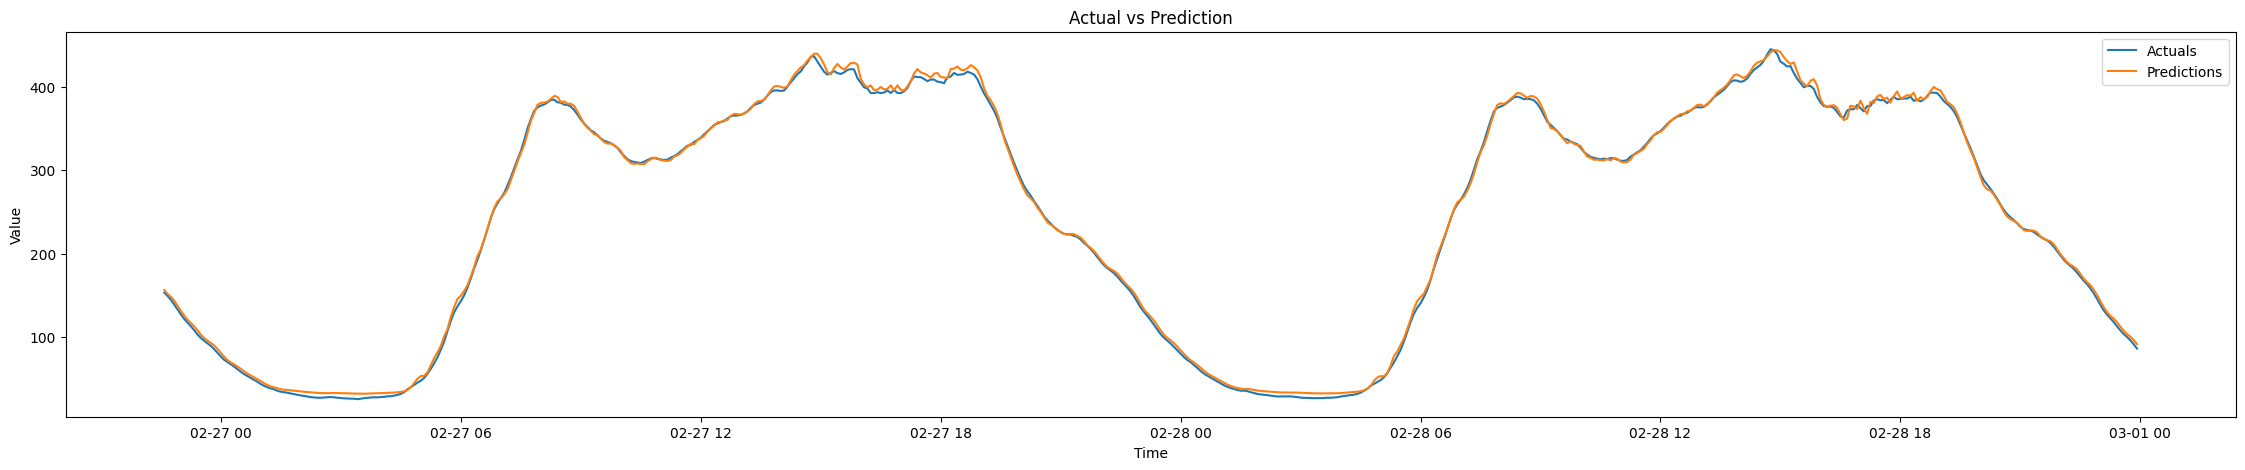

NEW Local
Federated
Round 1
RMSE:6.248, MAE:5.311, RMSPE:13.016 % , MAAPE:6.829 %


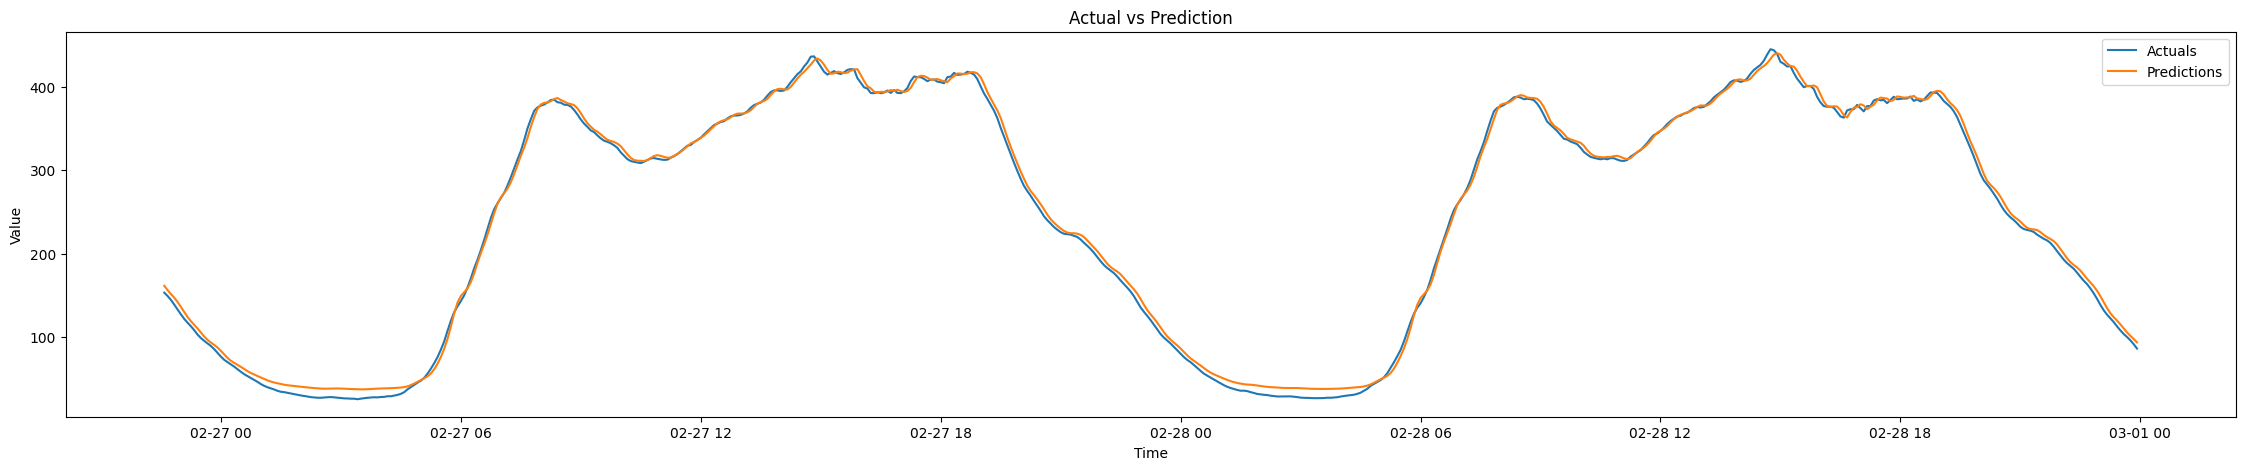

Round 2
RMSE:3.788, MAE:3.106, RMSPE:3.923 % , MAAPE:2.503 %


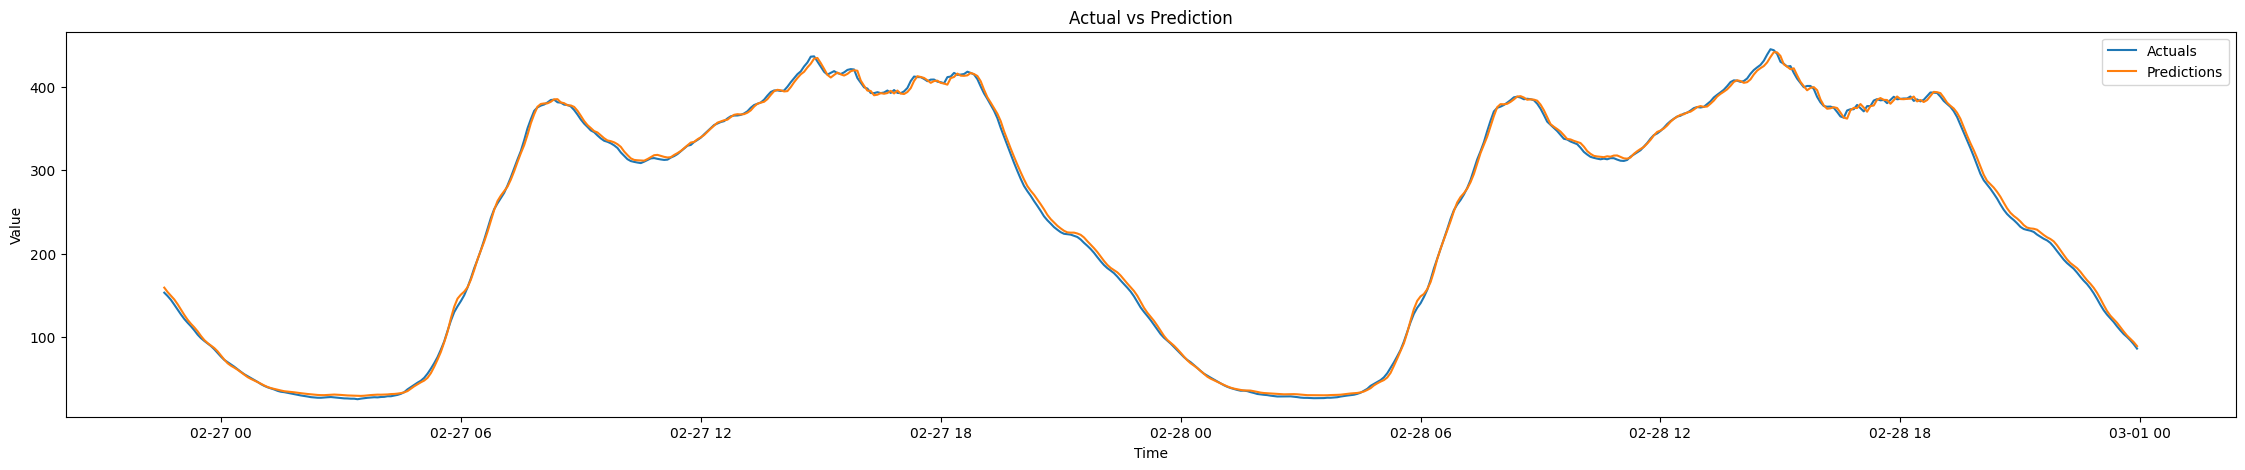

Round 3
RMSE:3.365, MAE:2.772, RMSPE:3.802 % , MAAPE:2.390 %


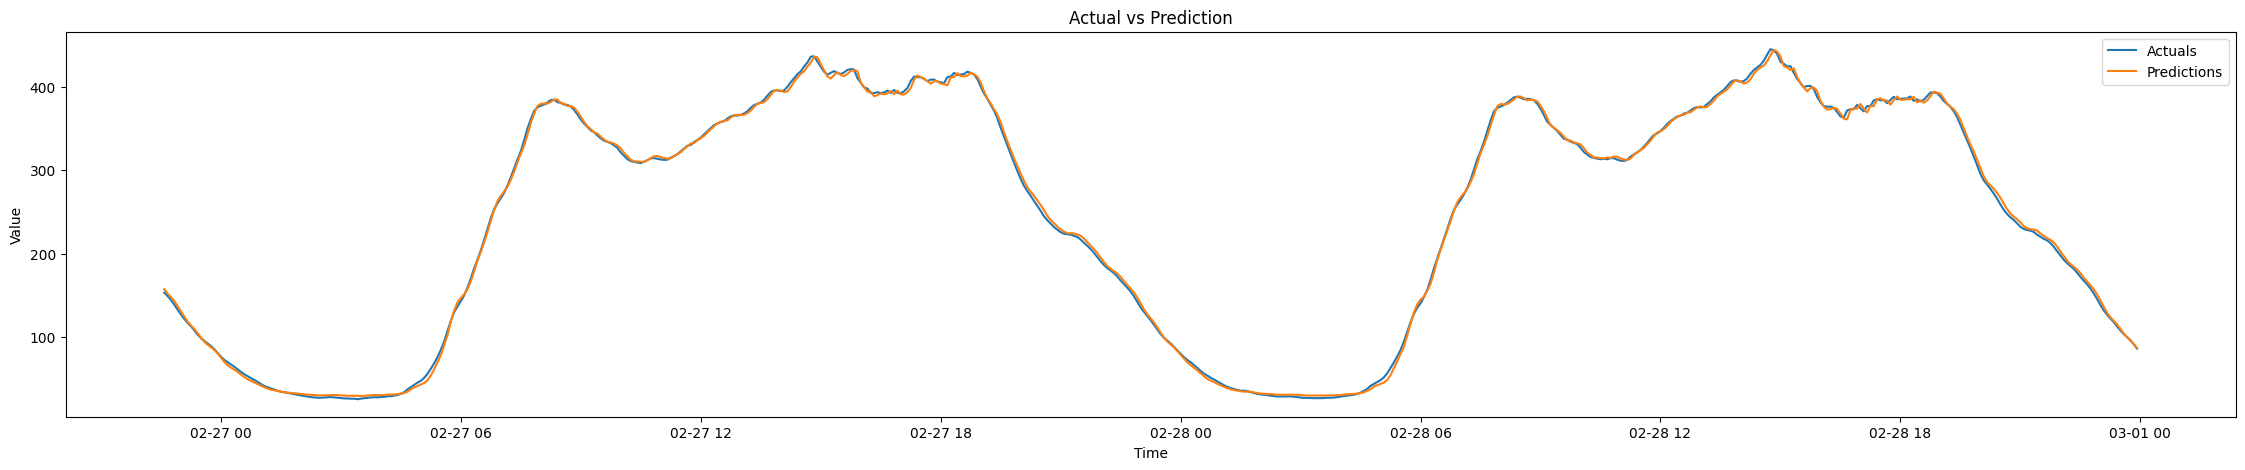

Round 4
RMSE:3.240, MAE:2.663, RMSPE:5.500 % , MAAPE:2.868 %


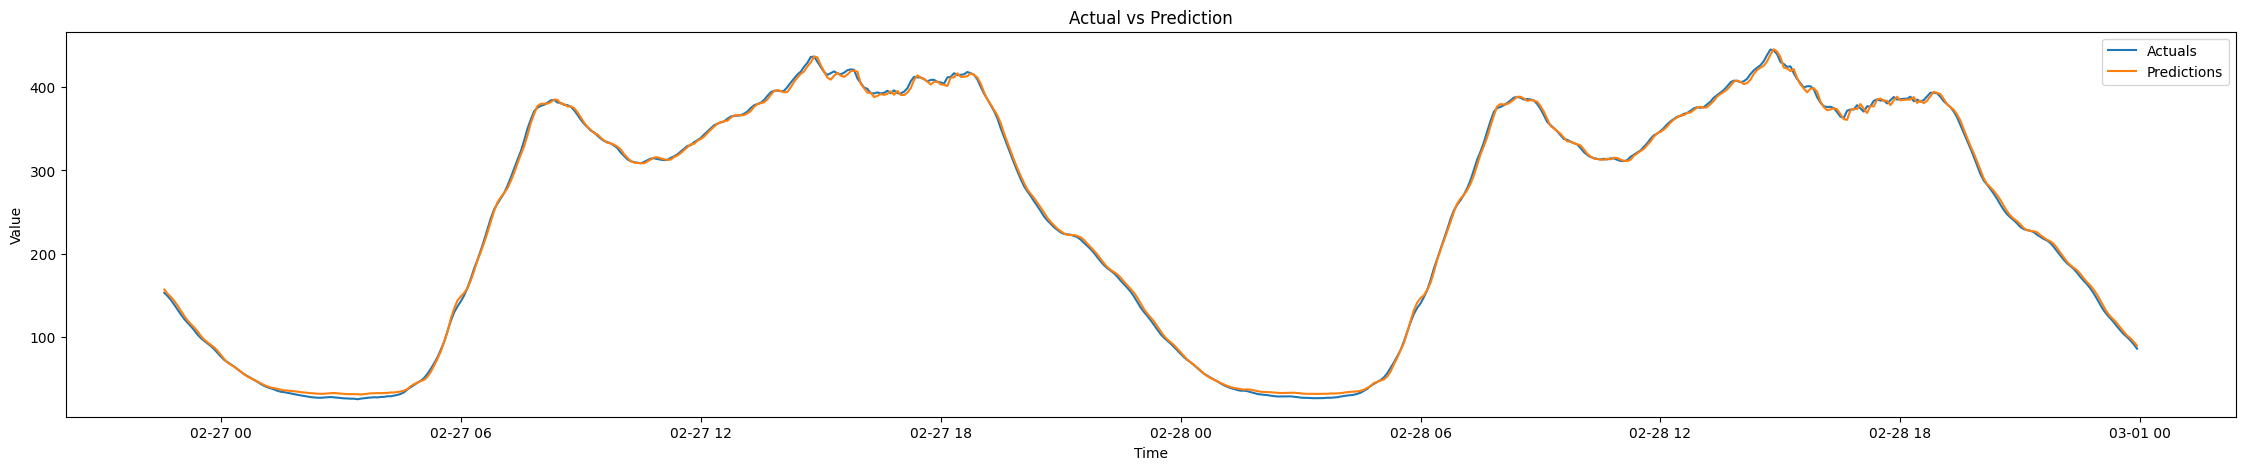

Round 5
RMSE:3.060, MAE:2.530, RMSPE:4.164 % , MAAPE:2.371 %


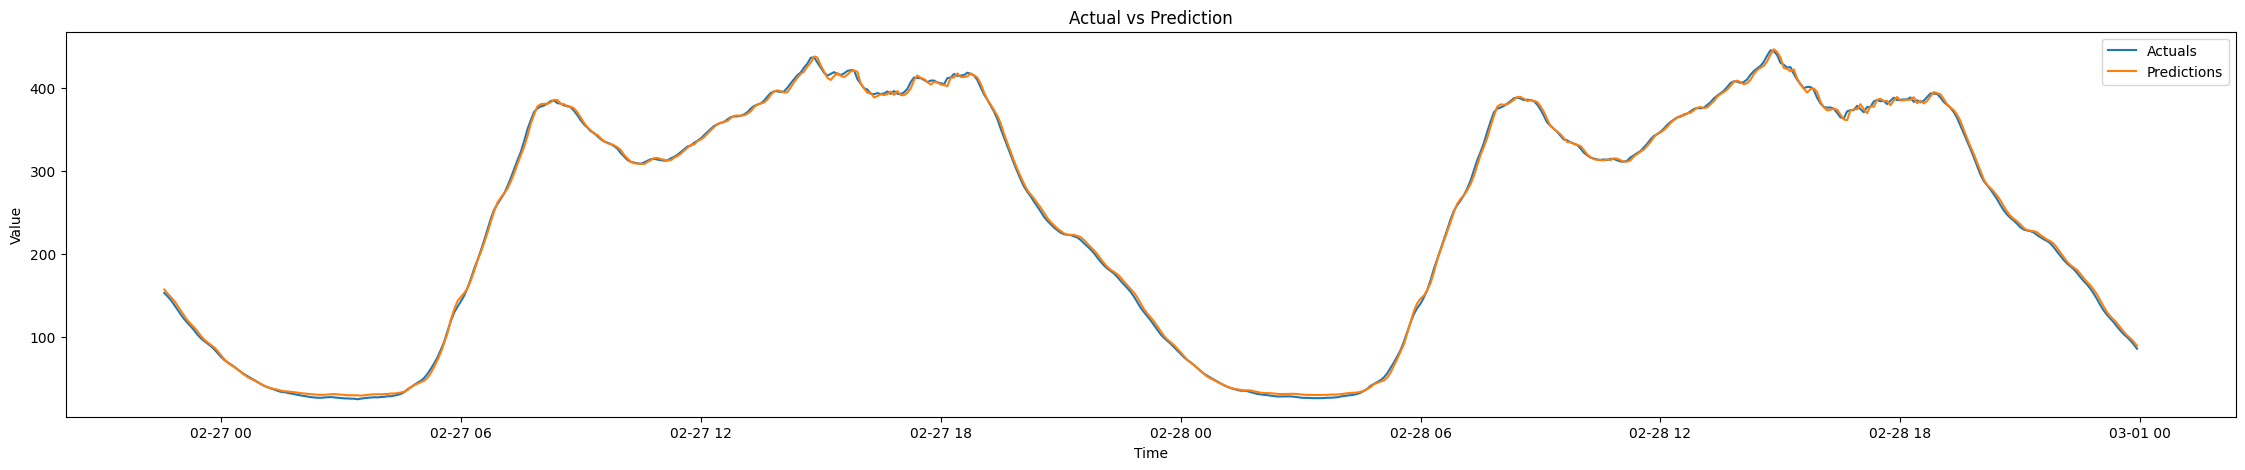

Round 6
RMSE:2.959, MAE:2.398, RMSPE:4.621 % , MAAPE:2.480 %


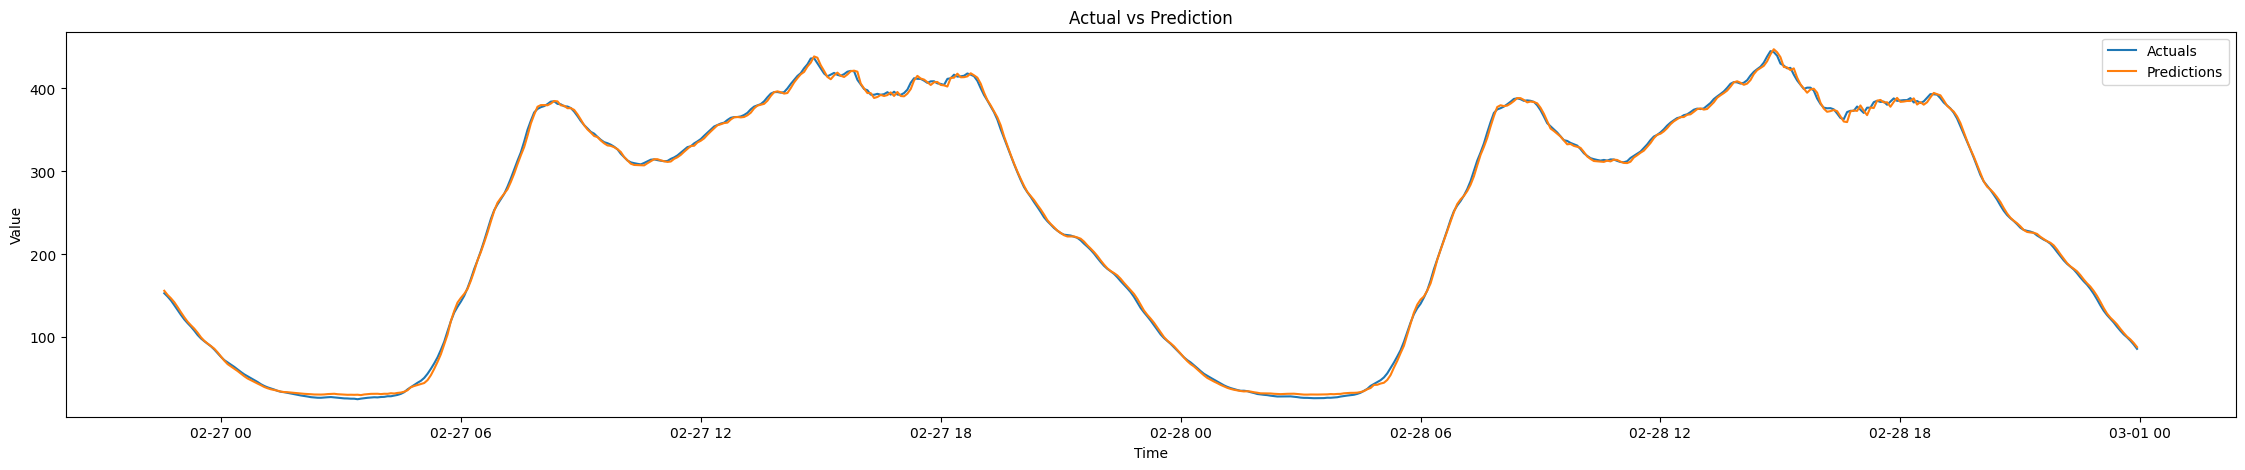

Round 7
RMSE:2.974, MAE:2.424, RMSPE:4.076 % , MAAPE:2.269 %


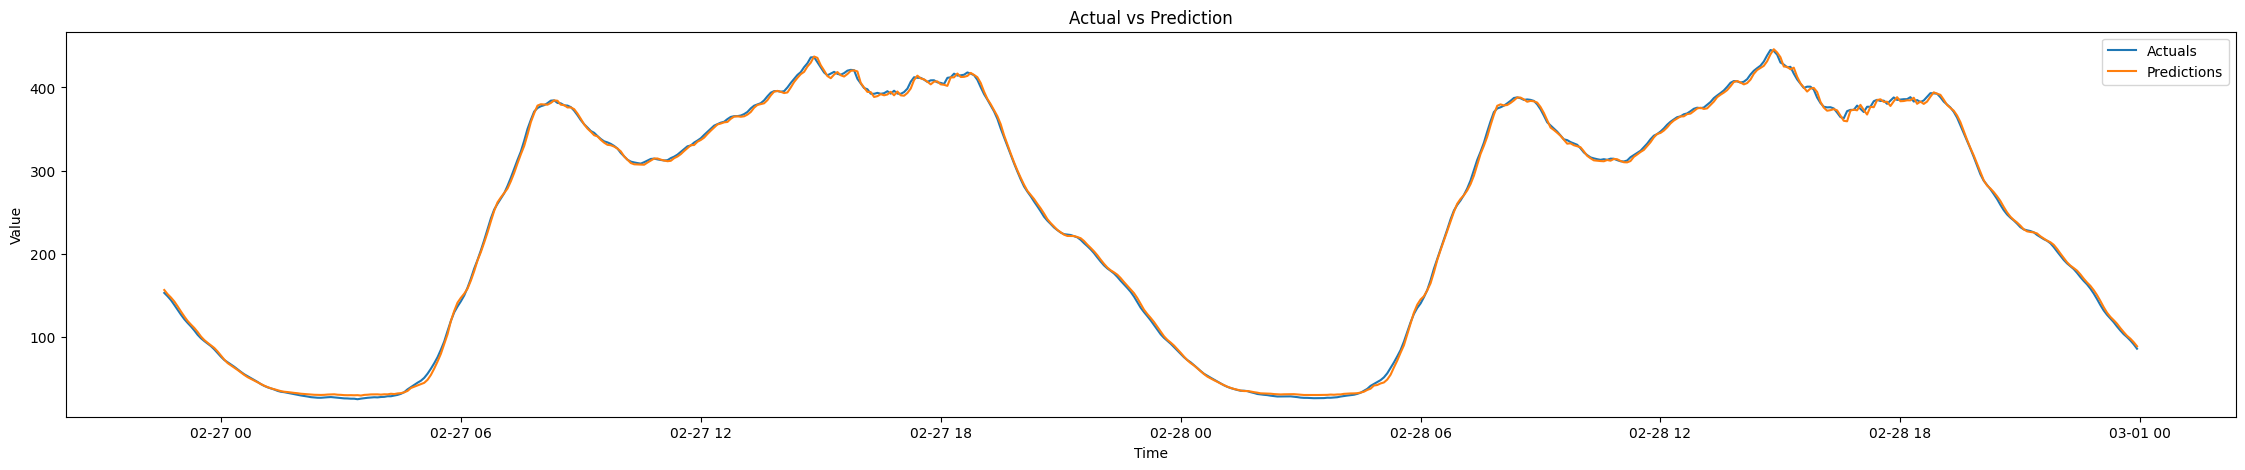

Round 8
RMSE:2.808, MAE:2.243, RMSPE:3.283 % , MAAPE:1.881 %


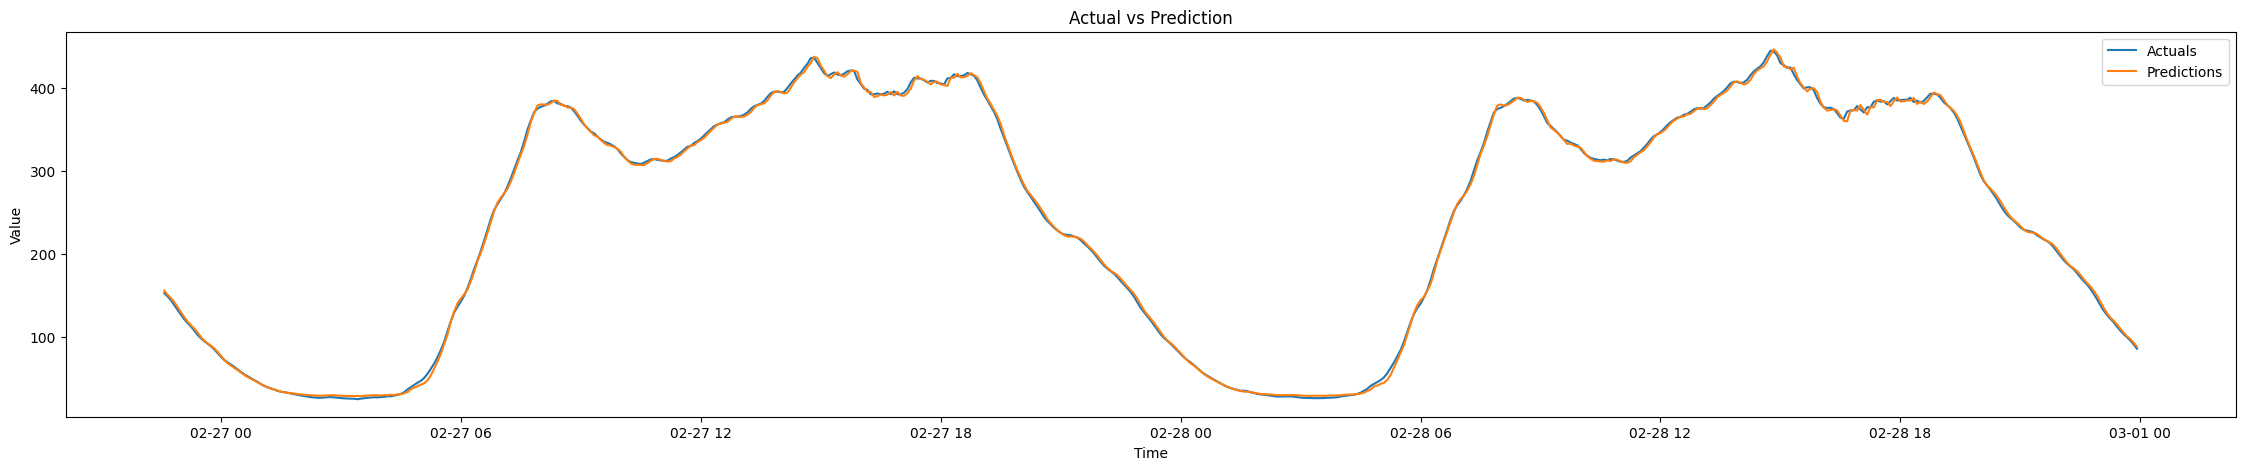

Round 9
RMSE:2.979, MAE:2.273, RMSPE:2.982 % , MAAPE:1.712 %


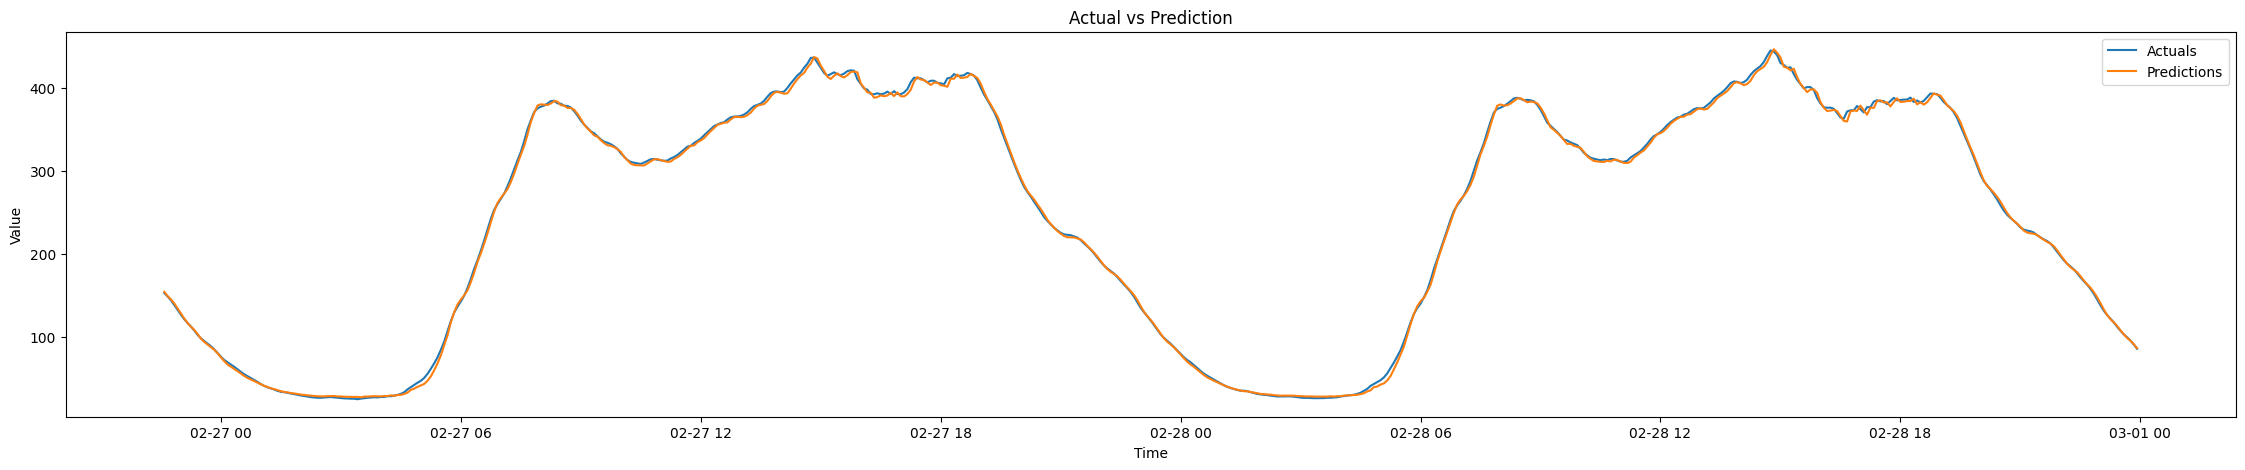

Round 10
RMSE:2.882, MAE:2.192, RMSPE:2.688 % , MAAPE:1.557 %


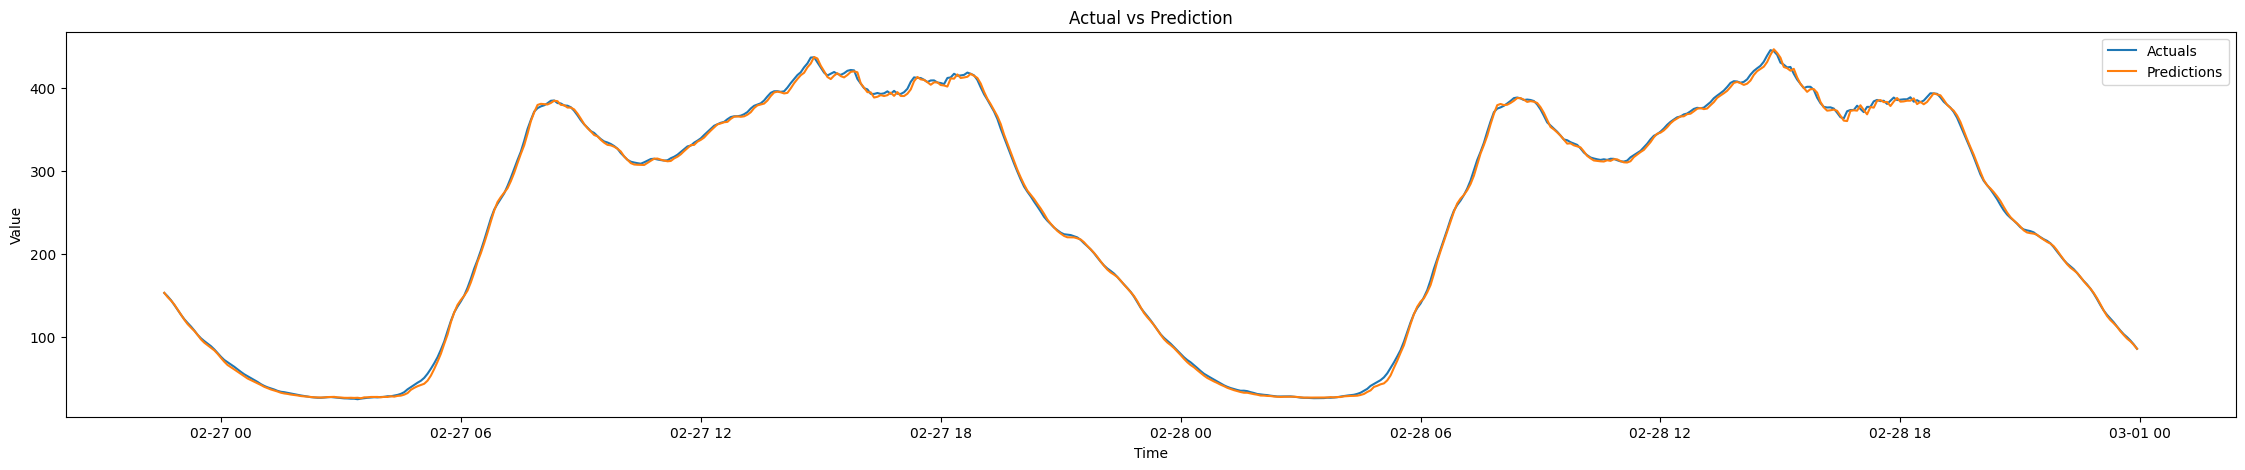

Round 11
RMSE:2.902, MAE:2.340, RMSPE:2.975 % , MAAPE:1.848 %


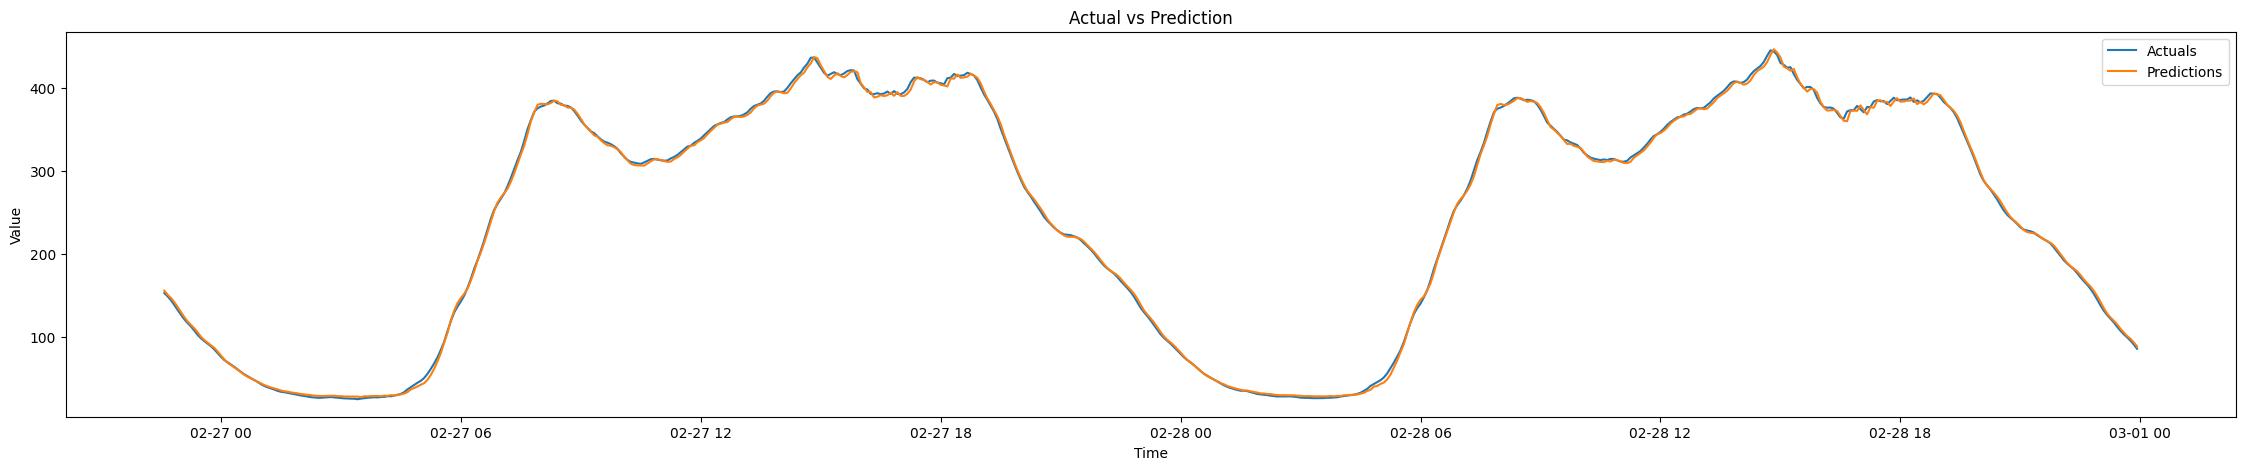

Round 12
RMSE:2.722, MAE:2.027, RMSPE:2.244 % , MAAPE:1.299 %


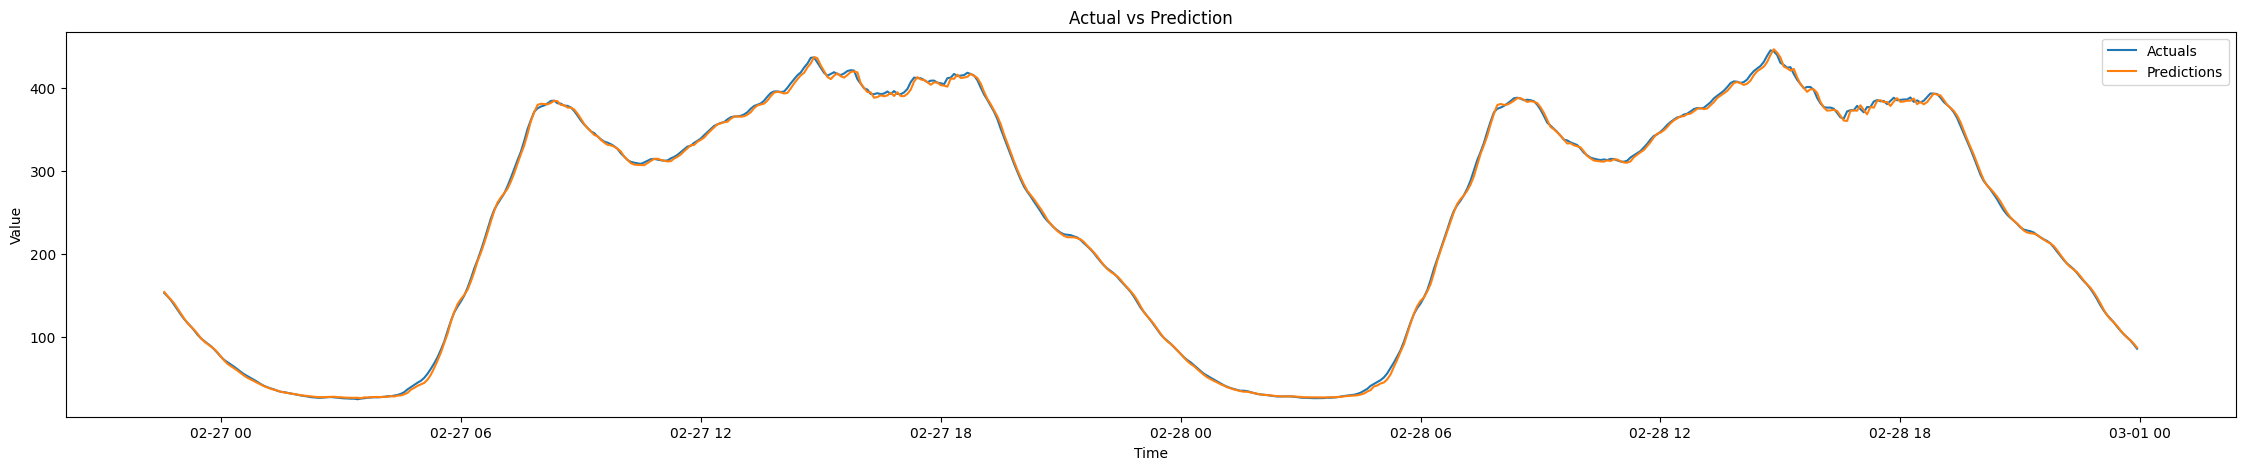

Round 13
RMSE:2.590, MAE:1.952, RMSPE:2.544 % , MAAPE:1.472 %


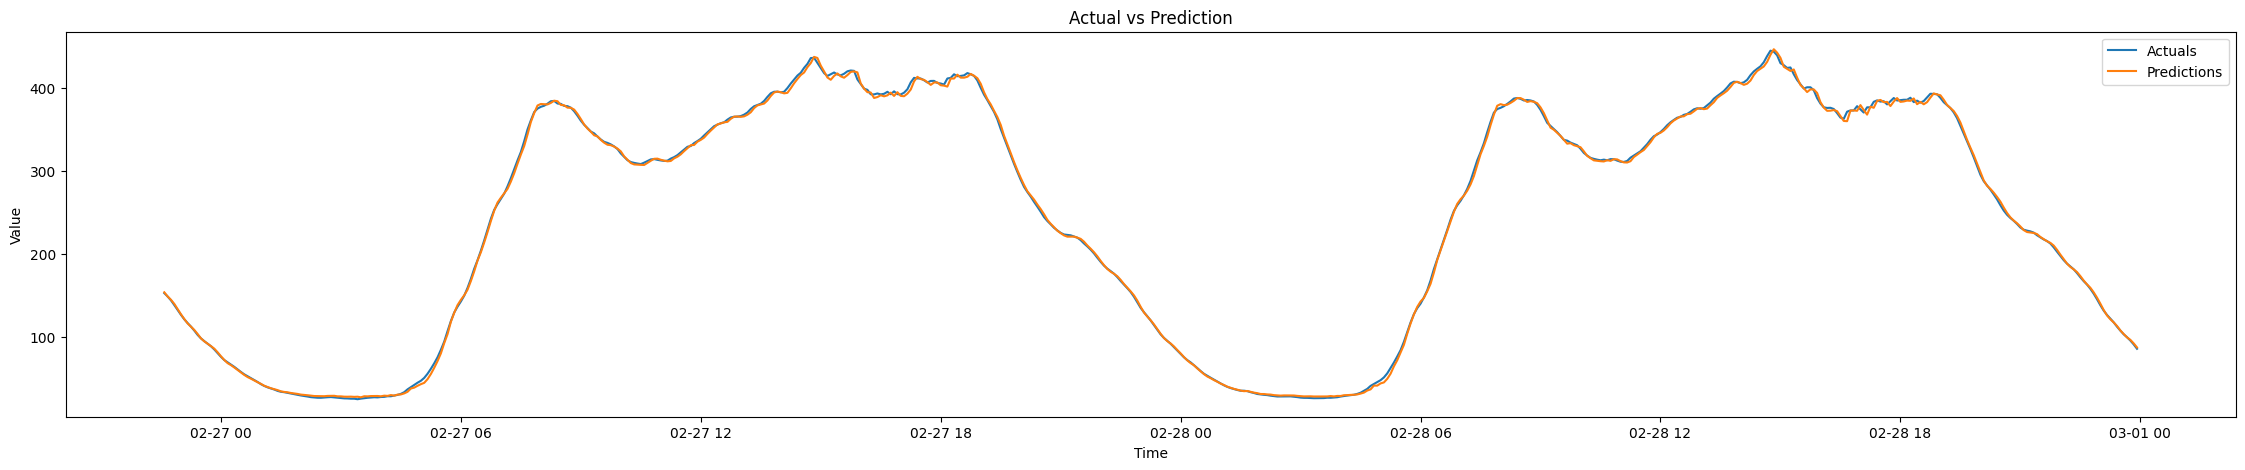

Round 14
RMSE:2.631, MAE:2.069, RMSPE:2.560 % , MAAPE:1.582 %


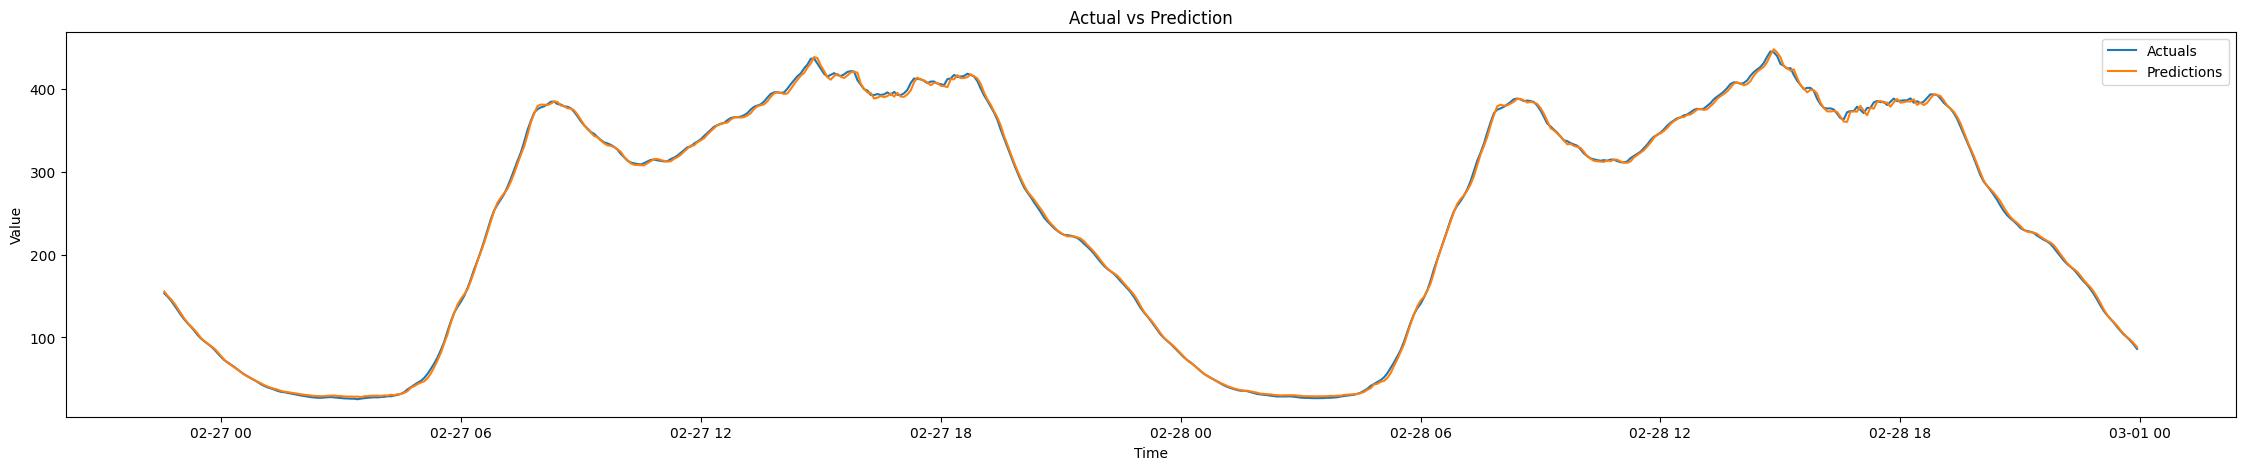

Round 15
RMSE:2.718, MAE:2.026, RMSPE:1.927 % , MAAPE:1.218 %


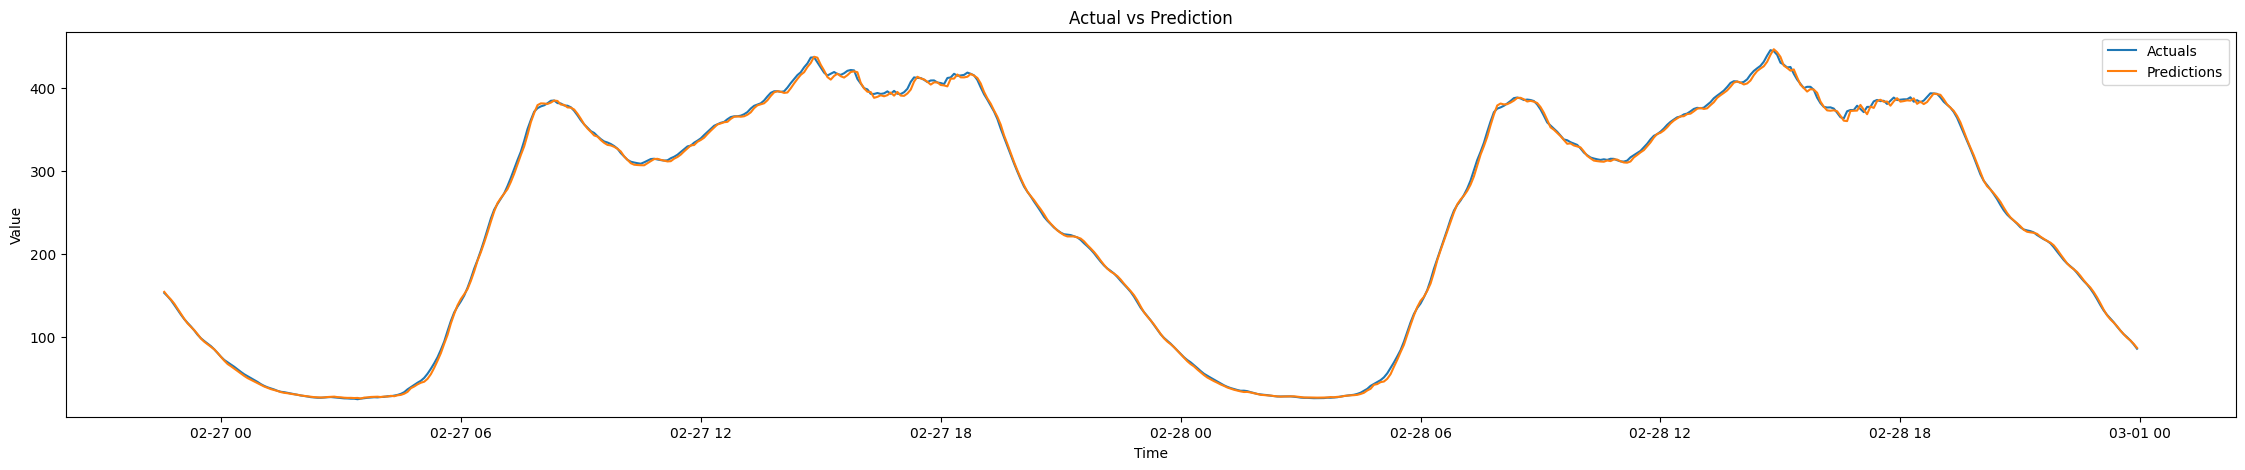

Round 16
RMSE:2.644, MAE:1.993, RMSPE:2.126 % , MAAPE:1.340 %


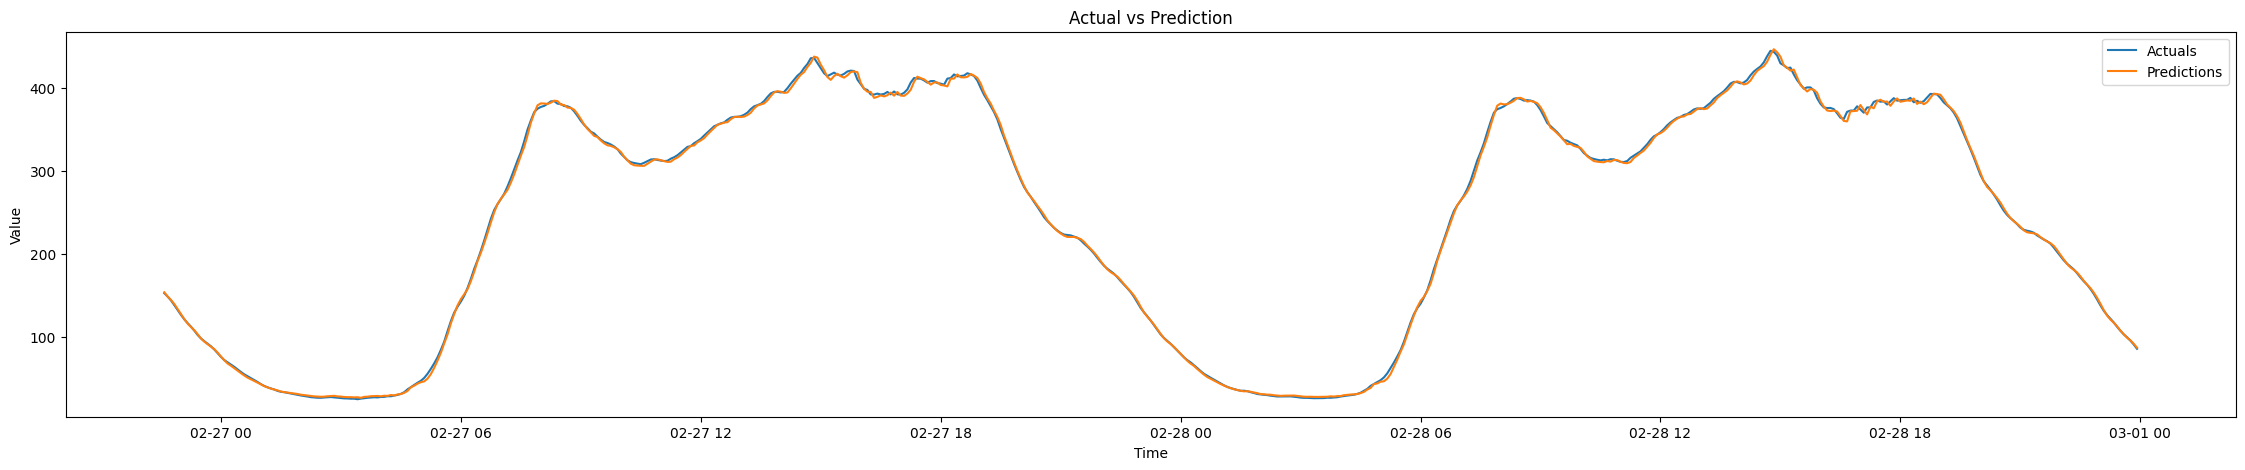

Round 17
RMSE:2.593, MAE:1.963, RMSPE:2.404 % , MAAPE:1.456 %


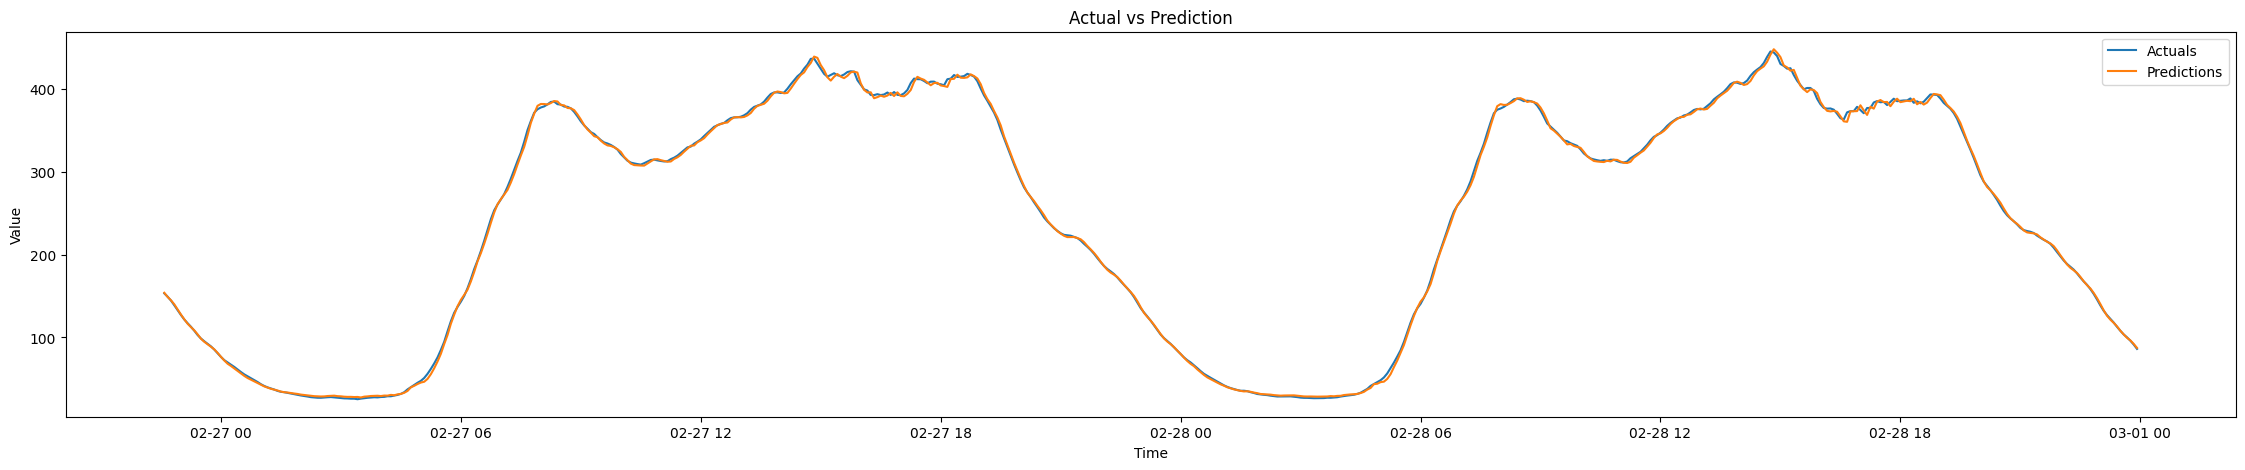

Round 18
RMSE:2.504, MAE:1.848, RMSPE:1.881 % , MAAPE:1.145 %


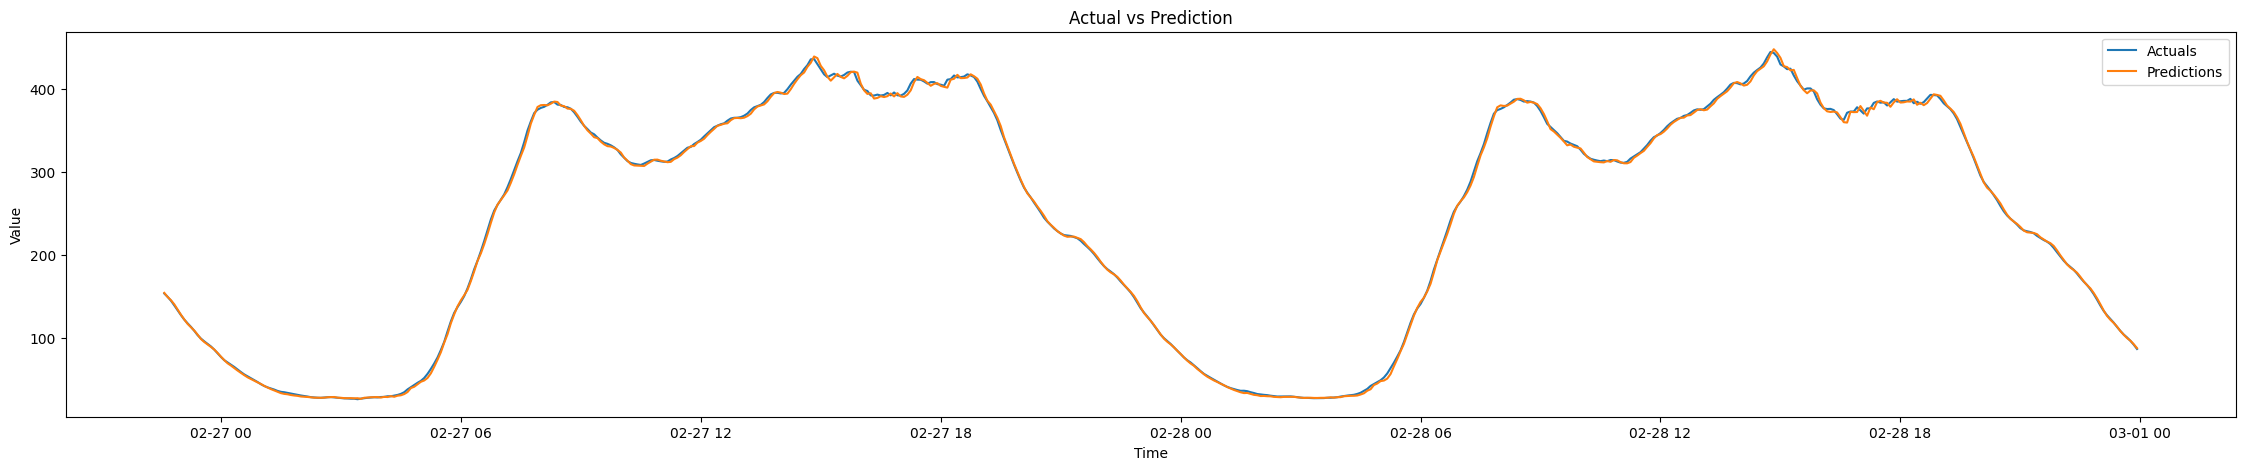

Round 19
RMSE:2.544, MAE:1.897, RMSPE:1.833 % , MAAPE:1.158 %


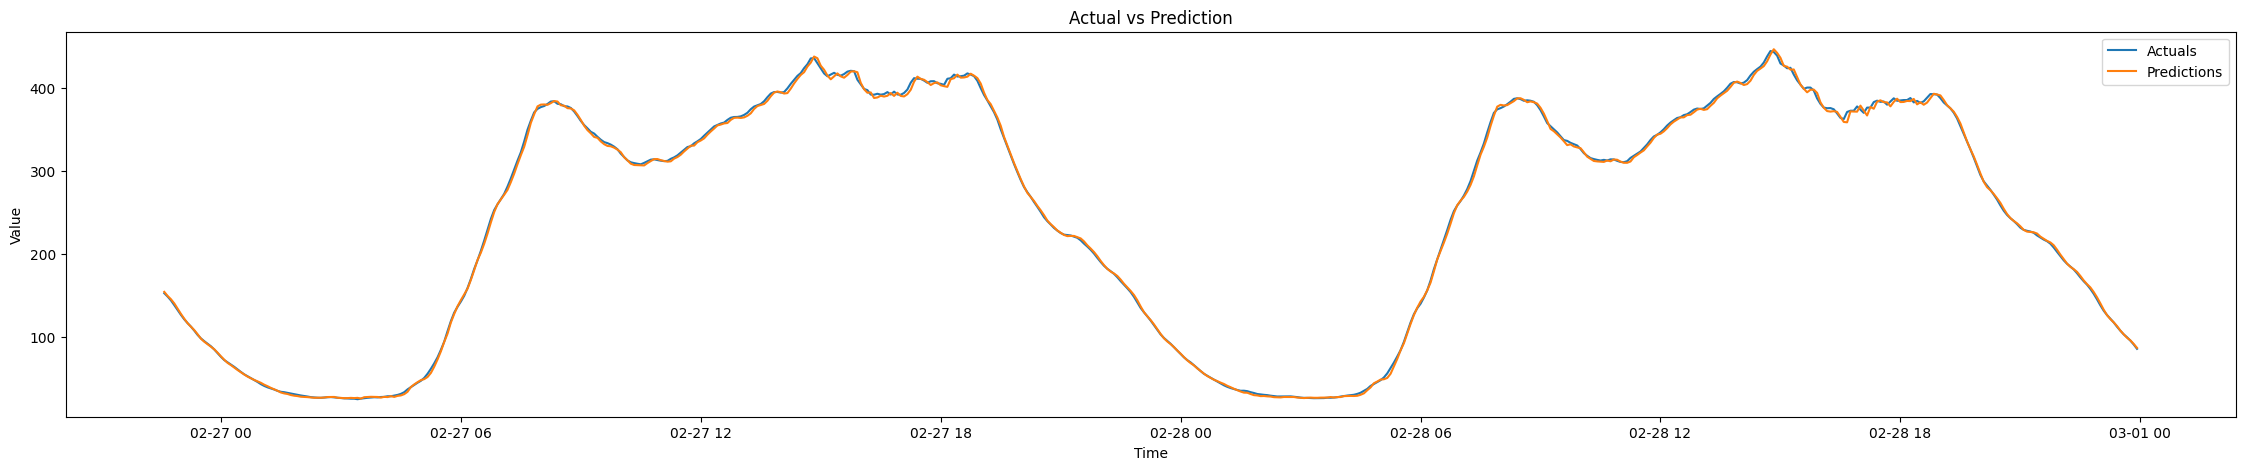

Round 20
RMSE:2.469, MAE:1.823, RMSPE:1.780 % , MAAPE:1.127 %


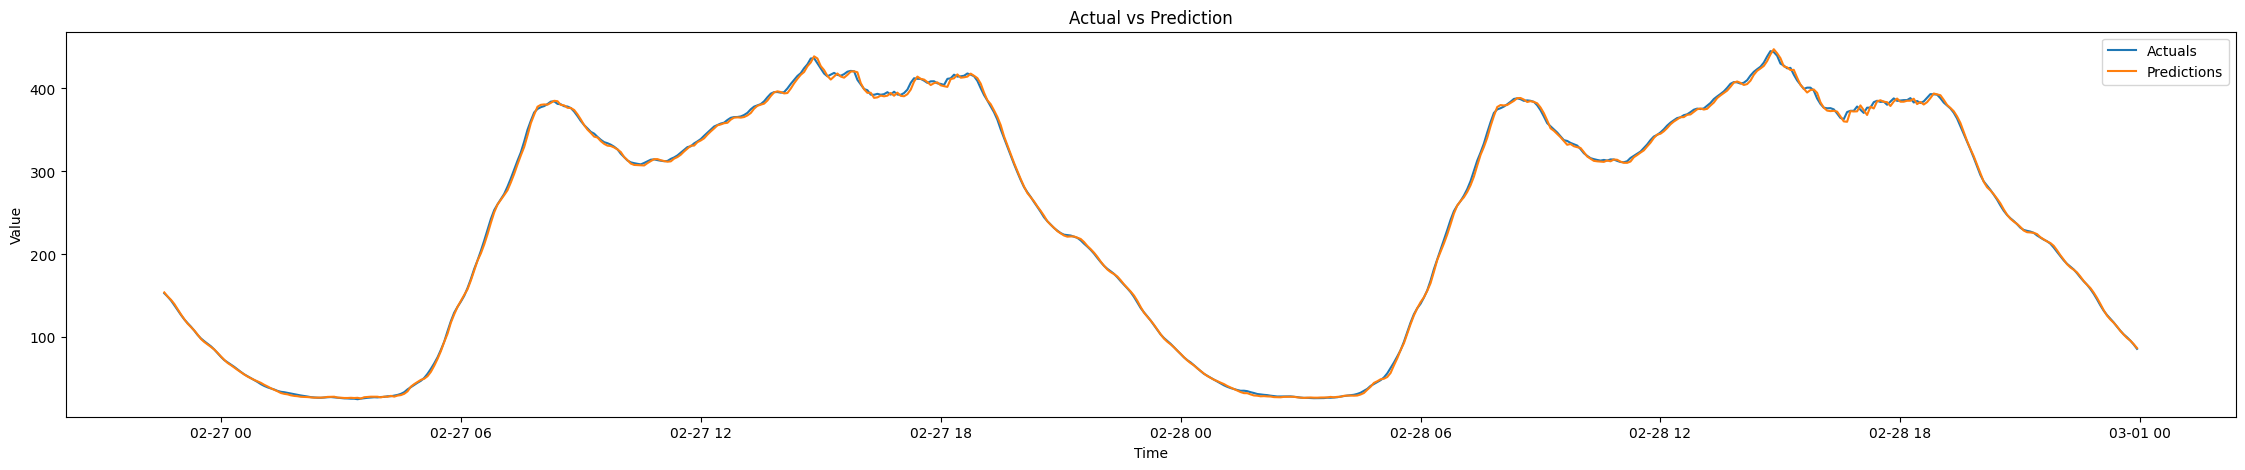

Round 21
RMSE:2.548, MAE:1.940, RMSPE:1.722 % , MAAPE:1.169 %


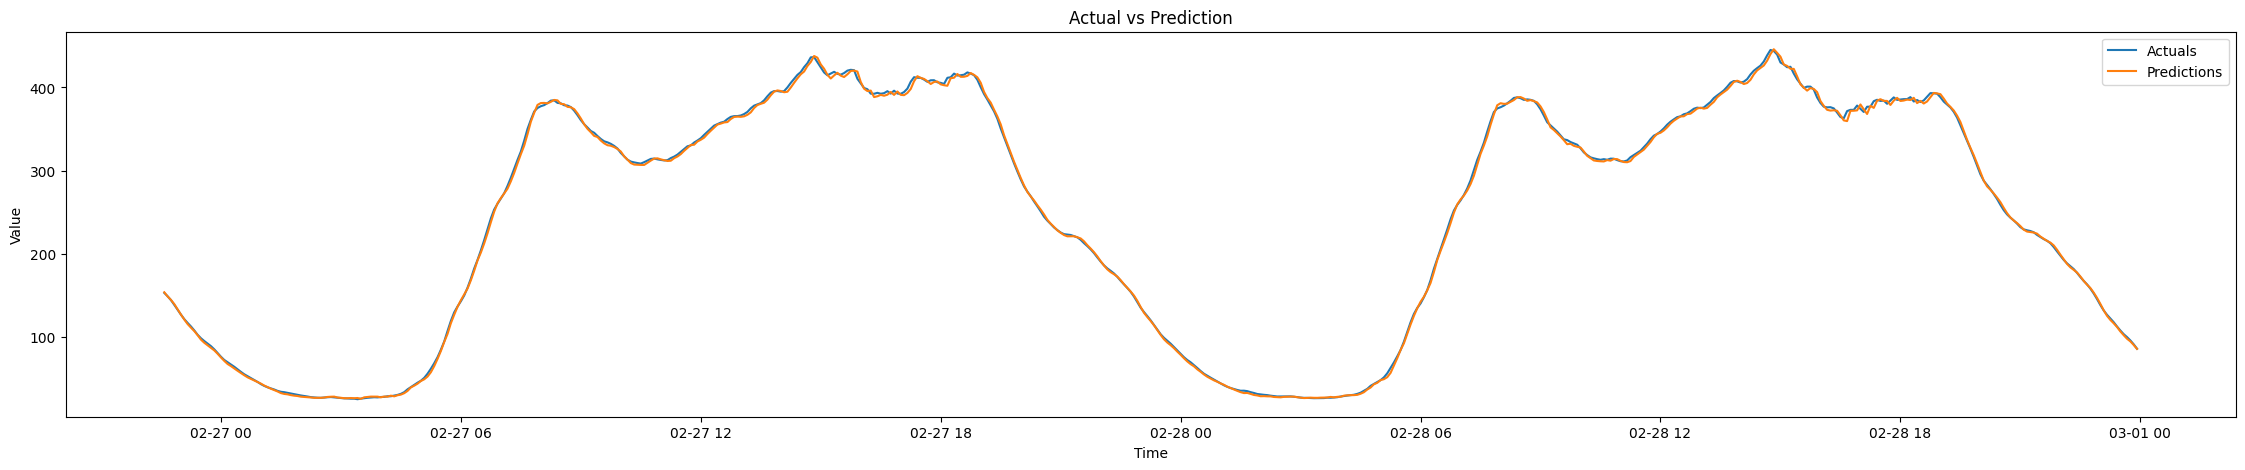

Round 22
RMSE:2.530, MAE:1.881, RMSPE:1.856 % , MAAPE:1.163 %


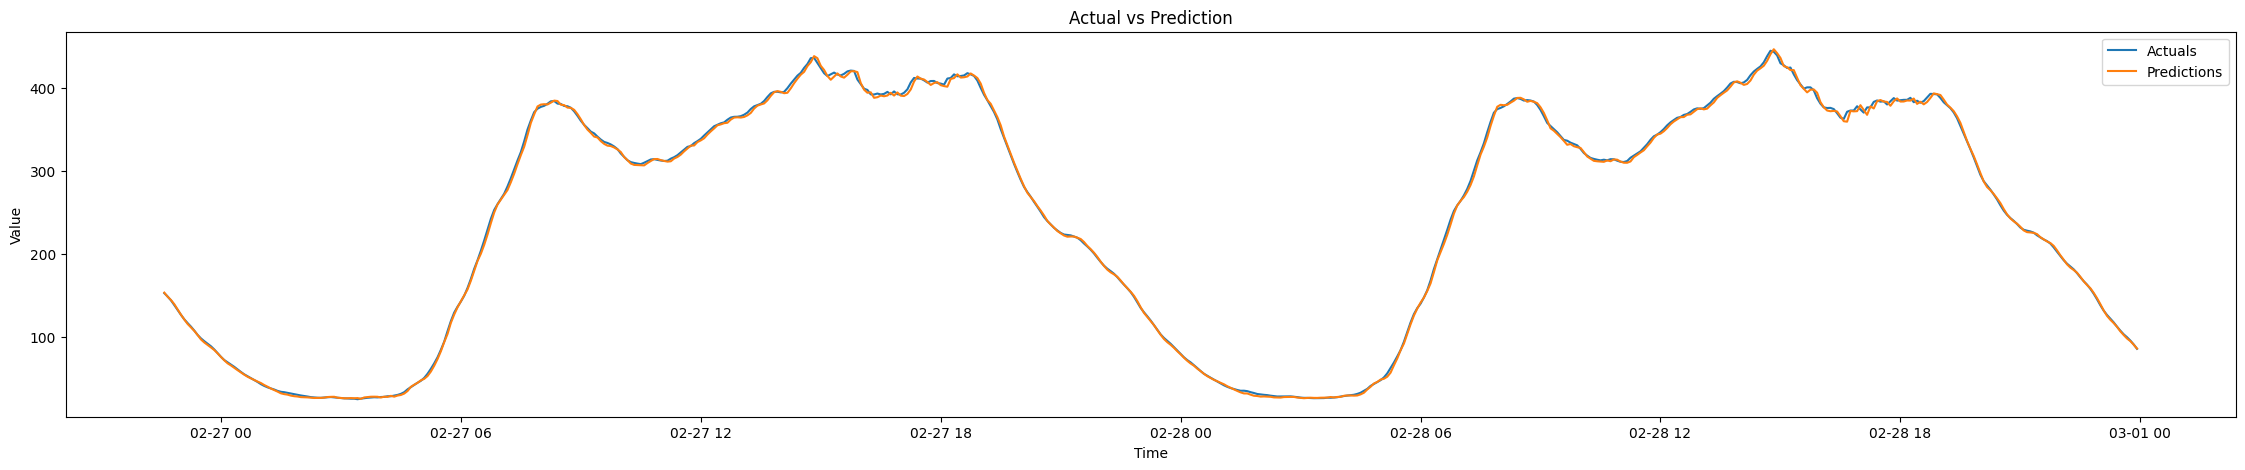

Round 23
RMSE:2.483, MAE:1.835, RMSPE:1.752 % , MAAPE:1.128 %


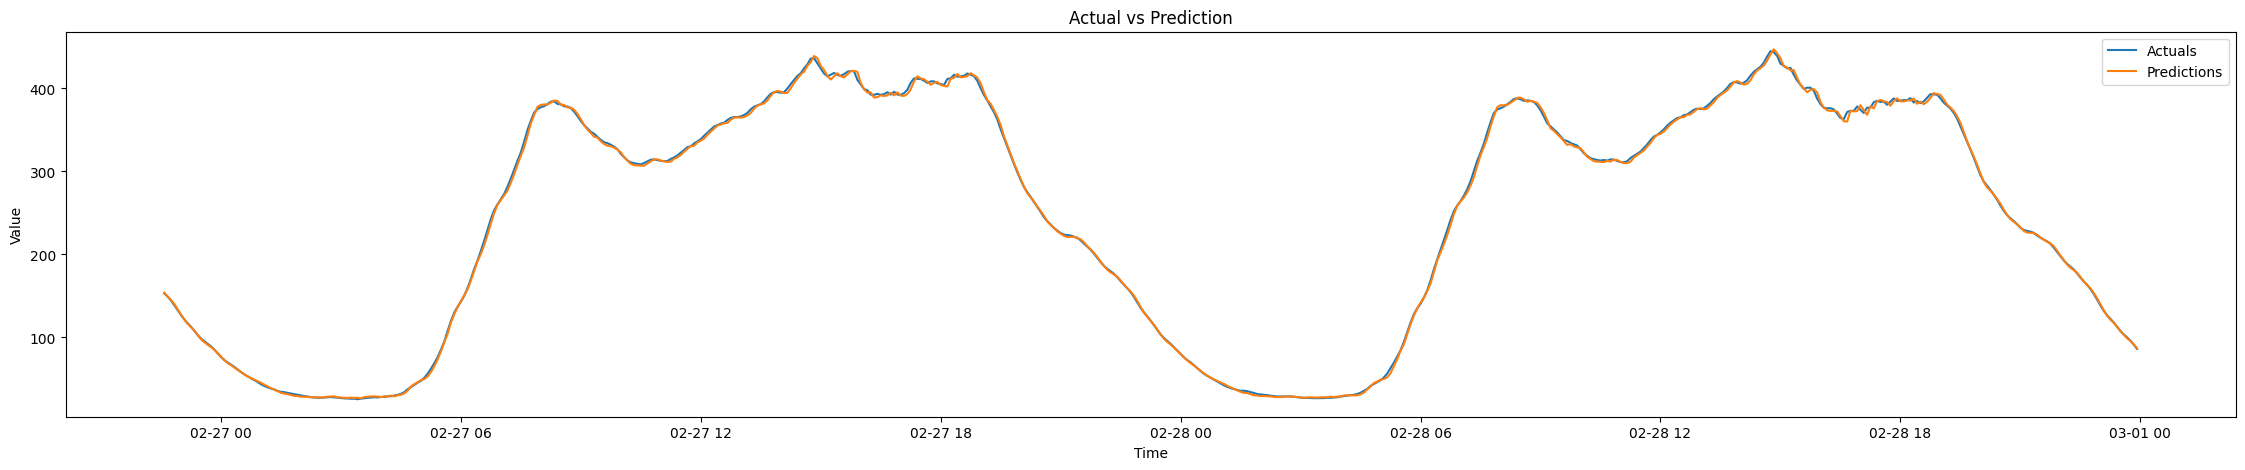

Round 24
RMSE:2.492, MAE:1.872, RMSPE:1.832 % , MAAPE:1.179 %


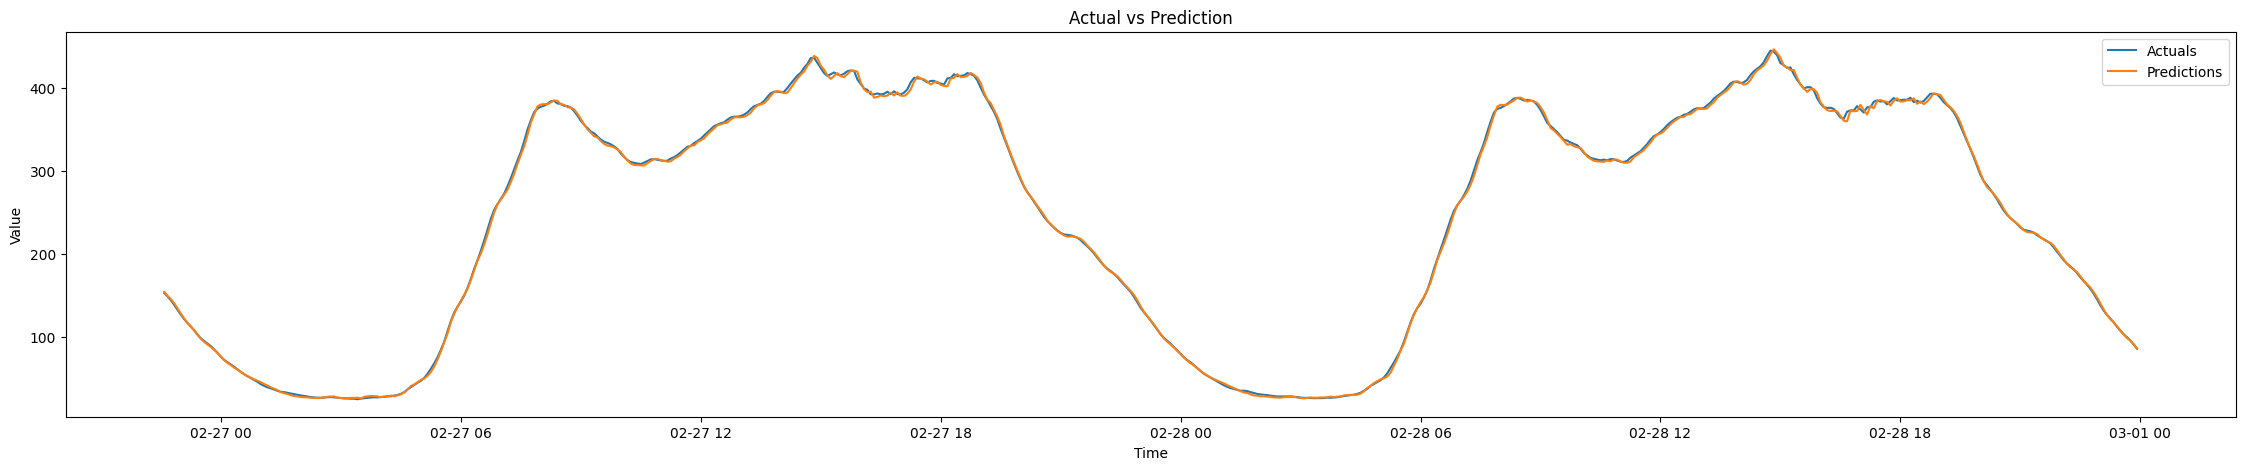

Round 25
RMSE:2.463, MAE:1.824, RMSPE:1.749 % , MAAPE:1.116 %


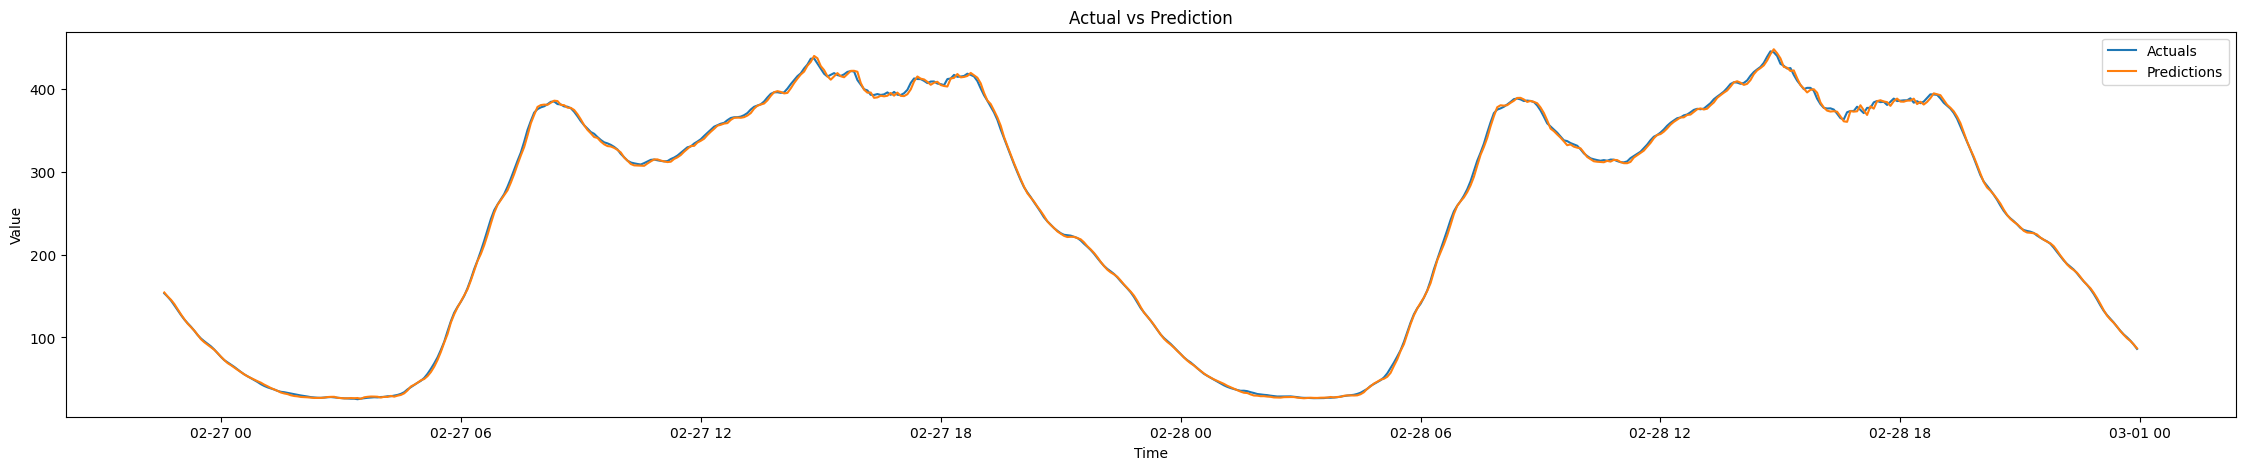

Round 26
RMSE:2.520, MAE:1.897, RMSPE:1.965 % , MAAPE:1.231 %


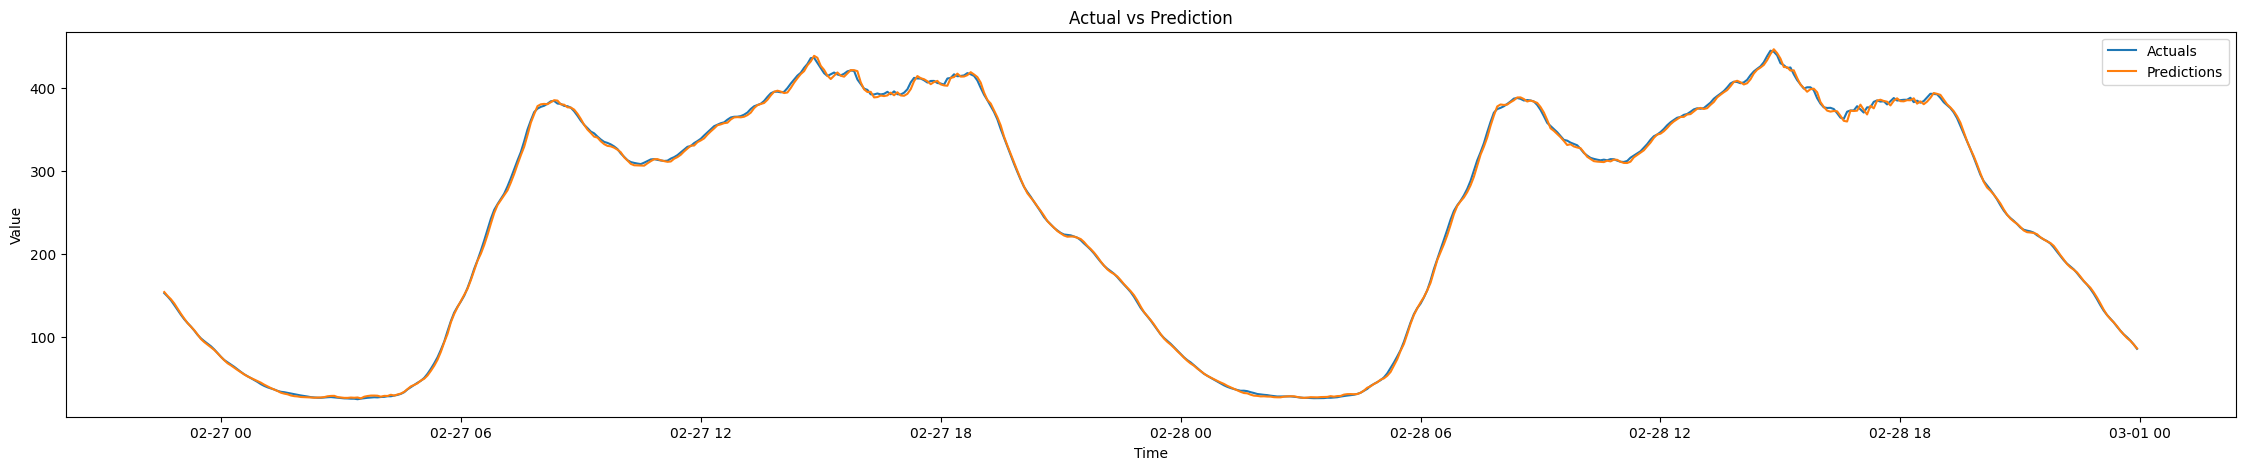

Round 27
RMSE:2.567, MAE:2.002, RMSPE:2.476 % , MAAPE:1.521 %


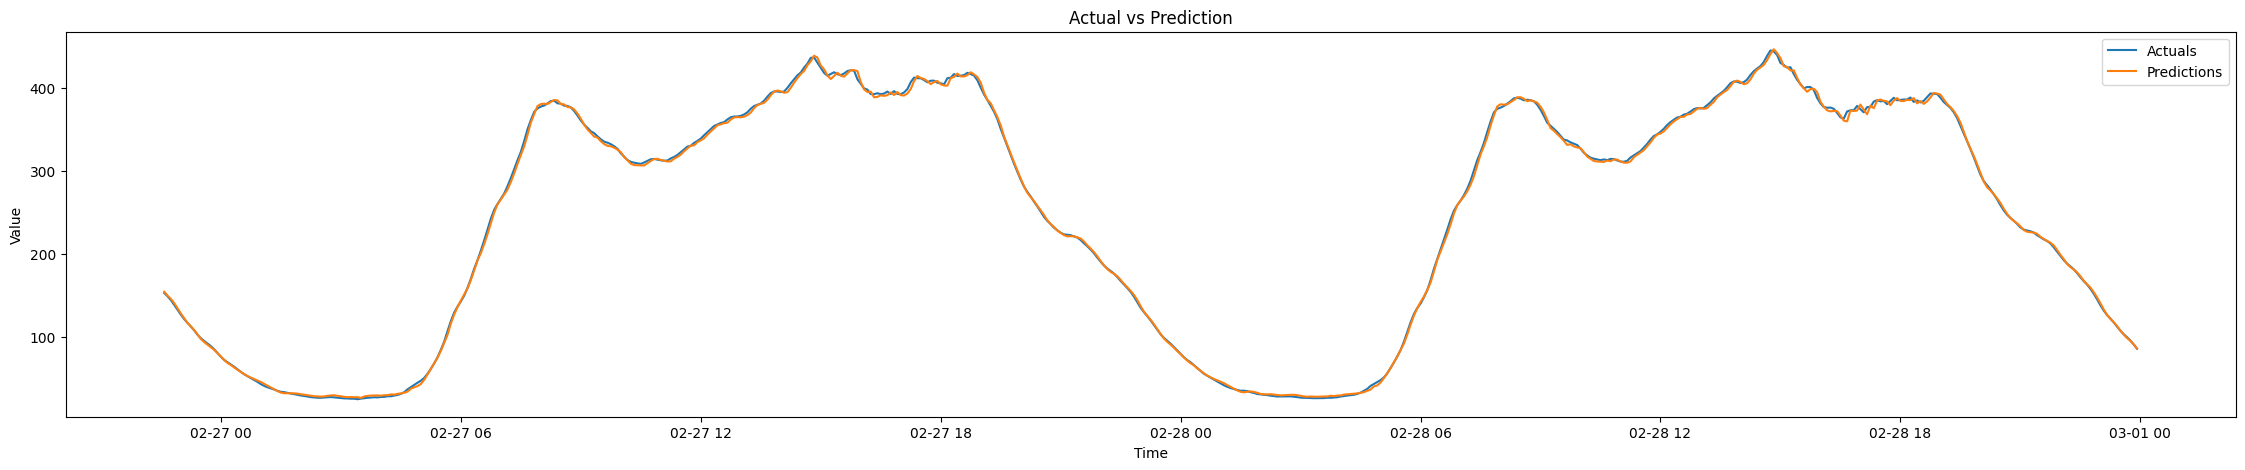

Round 28
RMSE:2.668, MAE:2.116, RMSPE:2.824 % , MAAPE:1.716 %


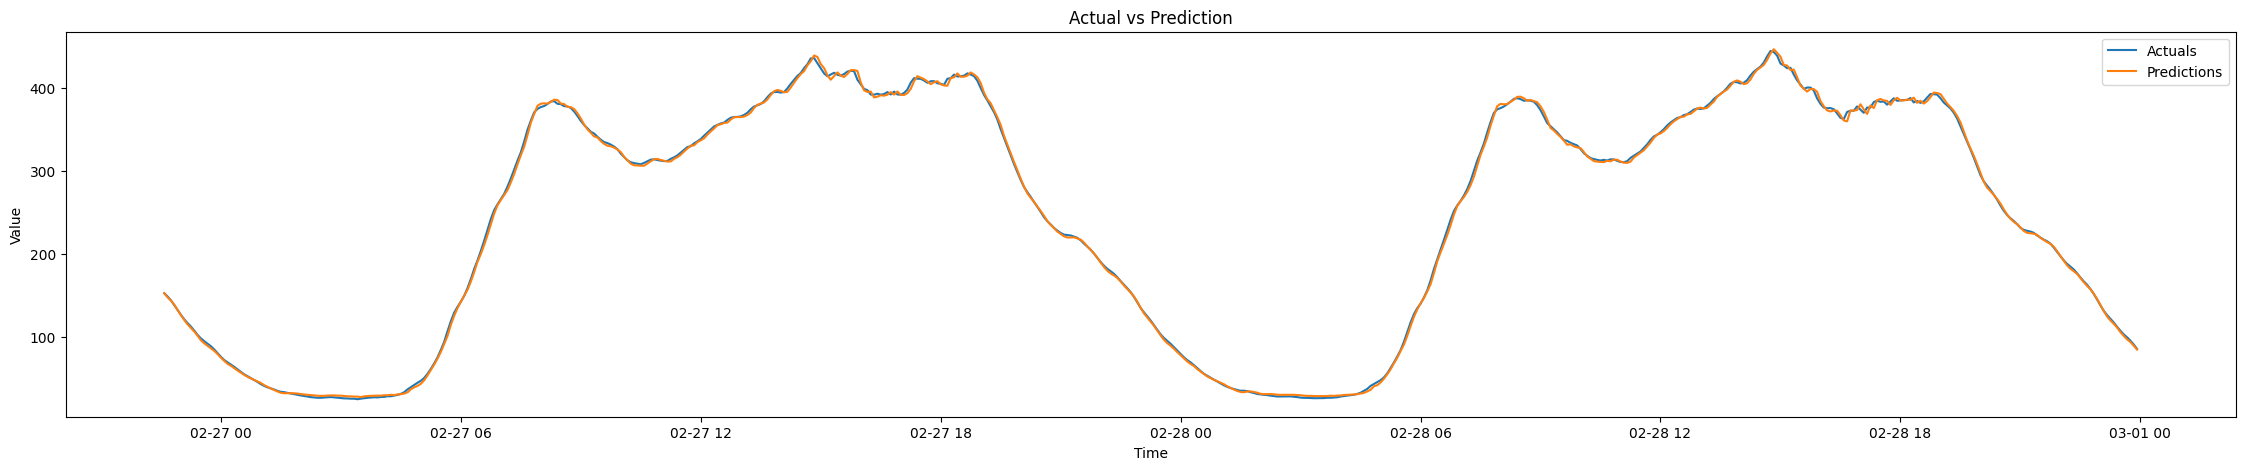

Round 29
RMSE:2.693, MAE:2.102, RMSPE:2.811 % , MAAPE:1.641 %


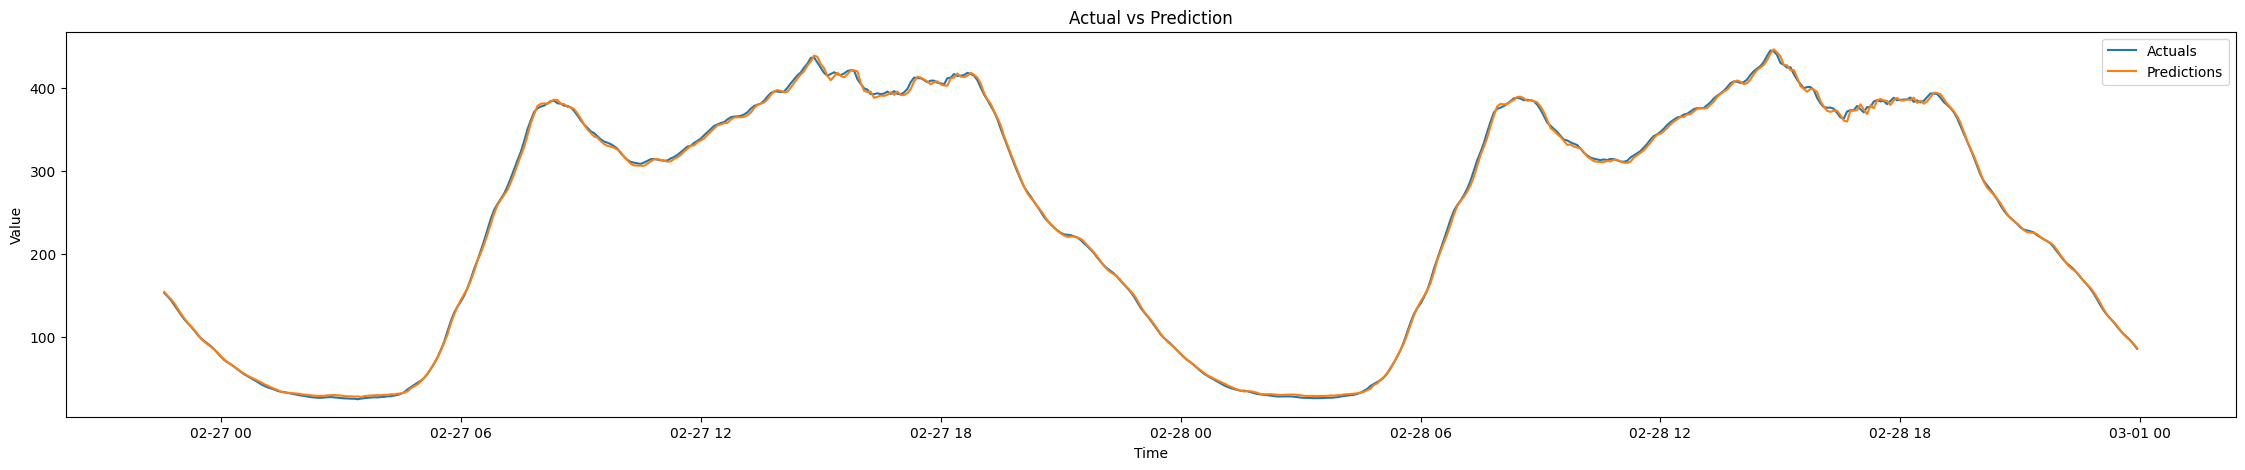

Round 30
RMSE:2.725, MAE:2.076, RMSPE:2.036 % , MAAPE:1.323 %


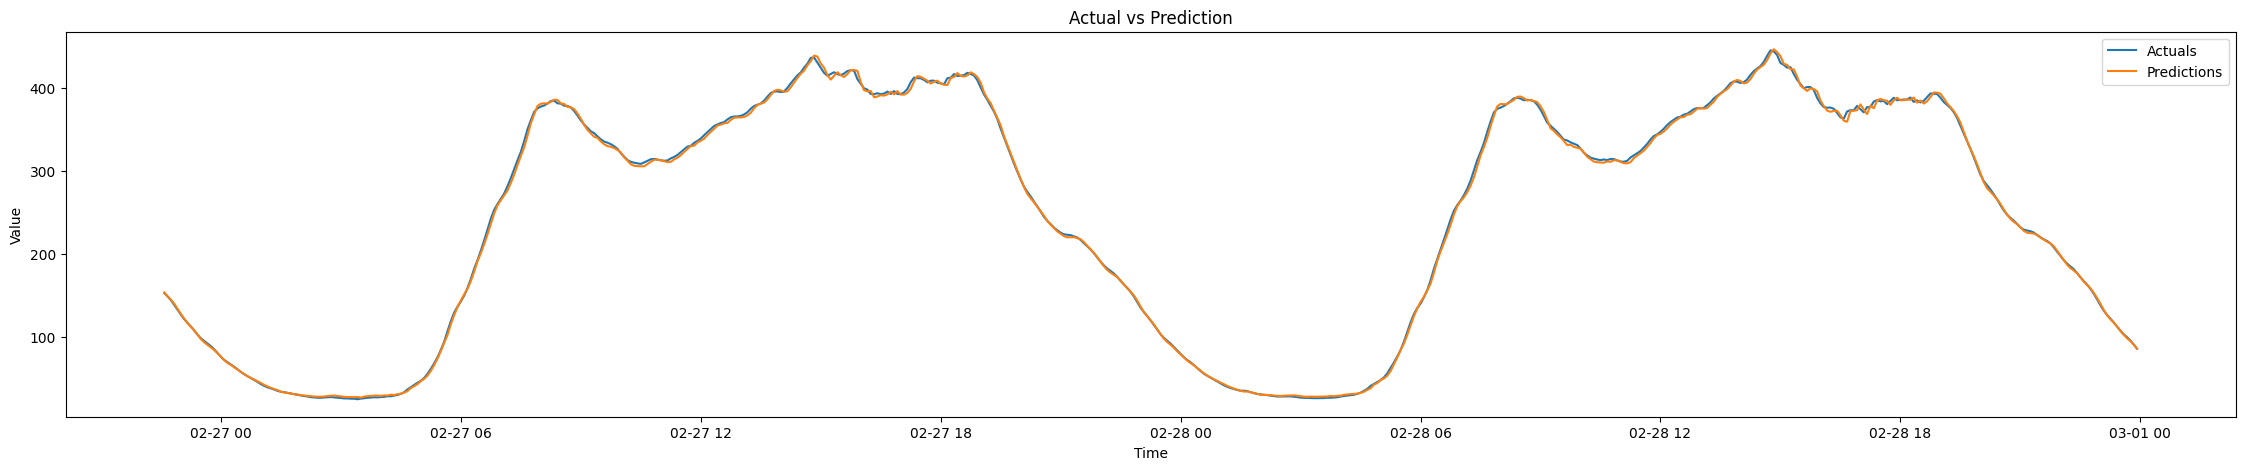

Round 31
RMSE:2.591, MAE:2.021, RMSPE:2.592 % , MAAPE:1.547 %


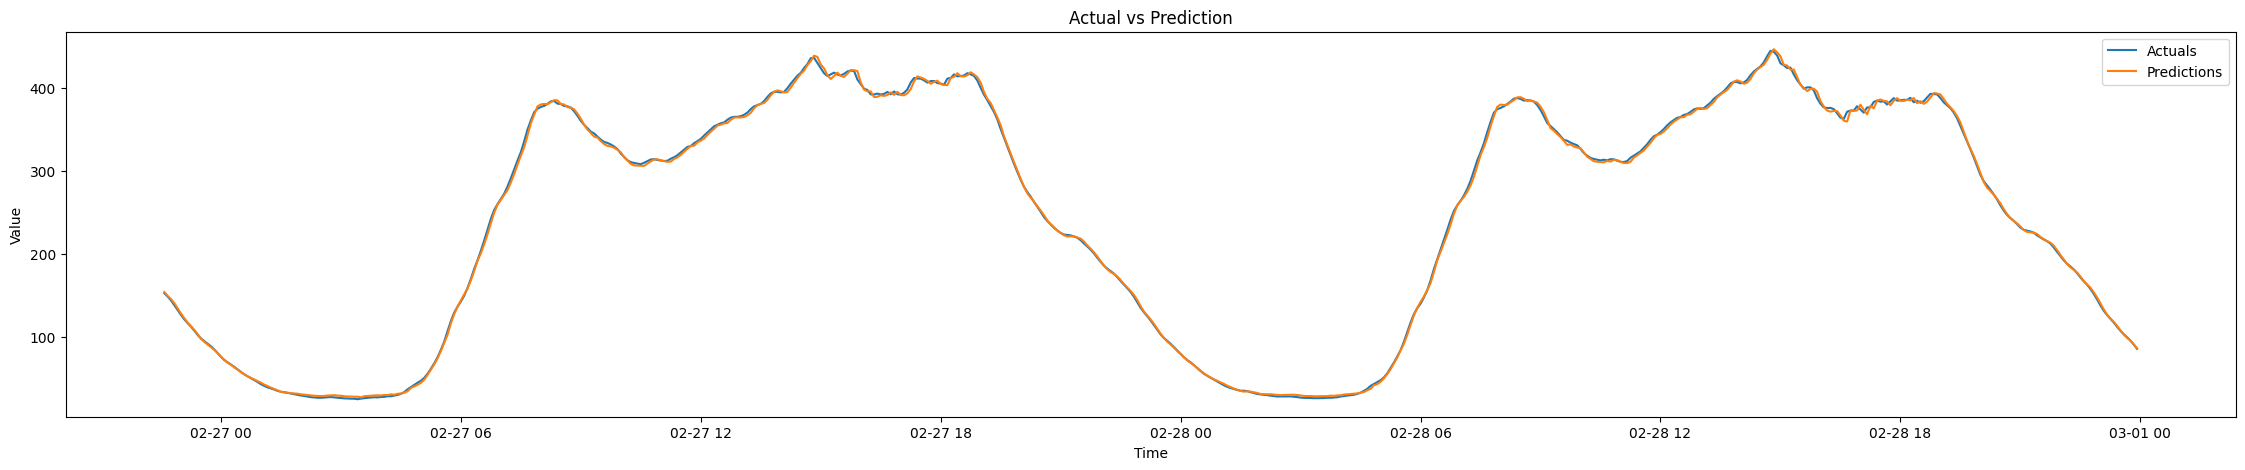

Round 32
RMSE:2.574, MAE:2.008, RMSPE:2.447 % , MAAPE:1.515 %


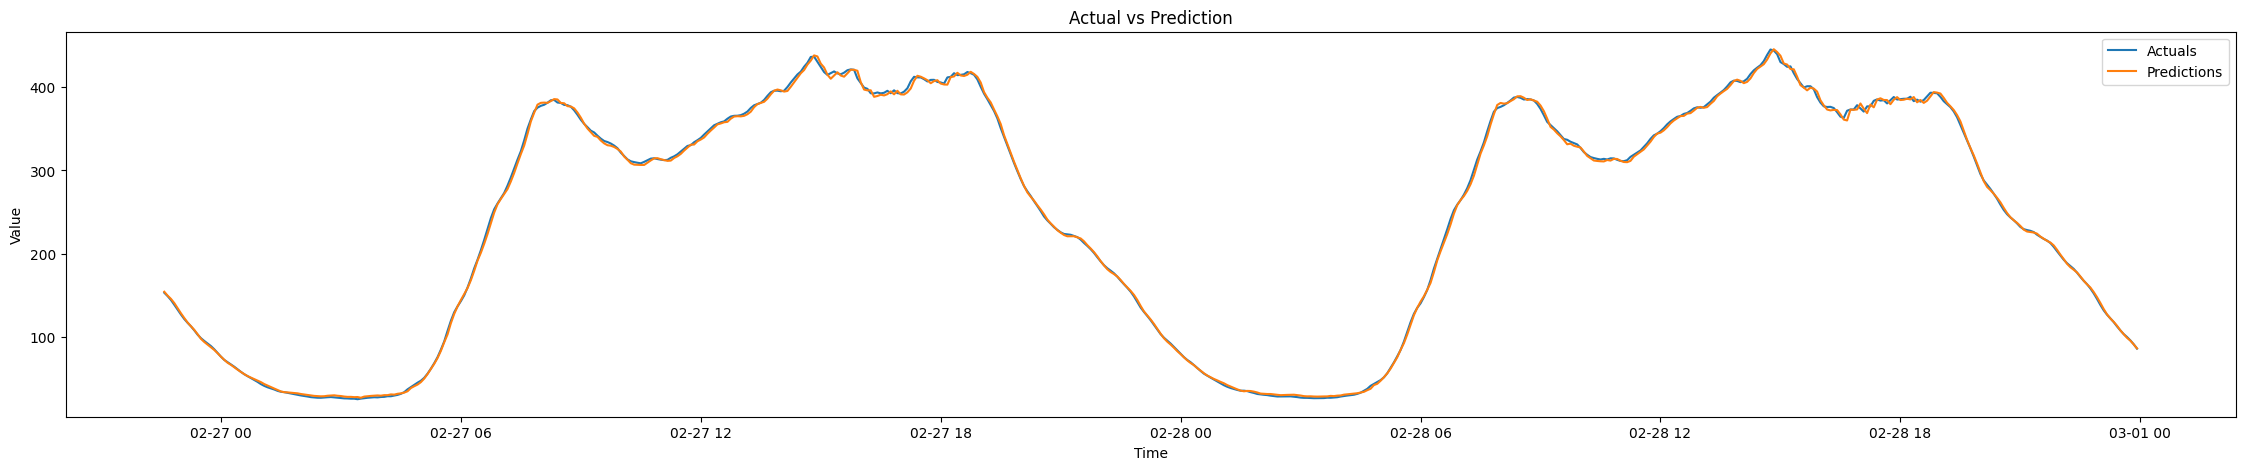

Round 33
RMSE:2.630, MAE:2.067, RMSPE:2.411 % , MAAPE:1.512 %


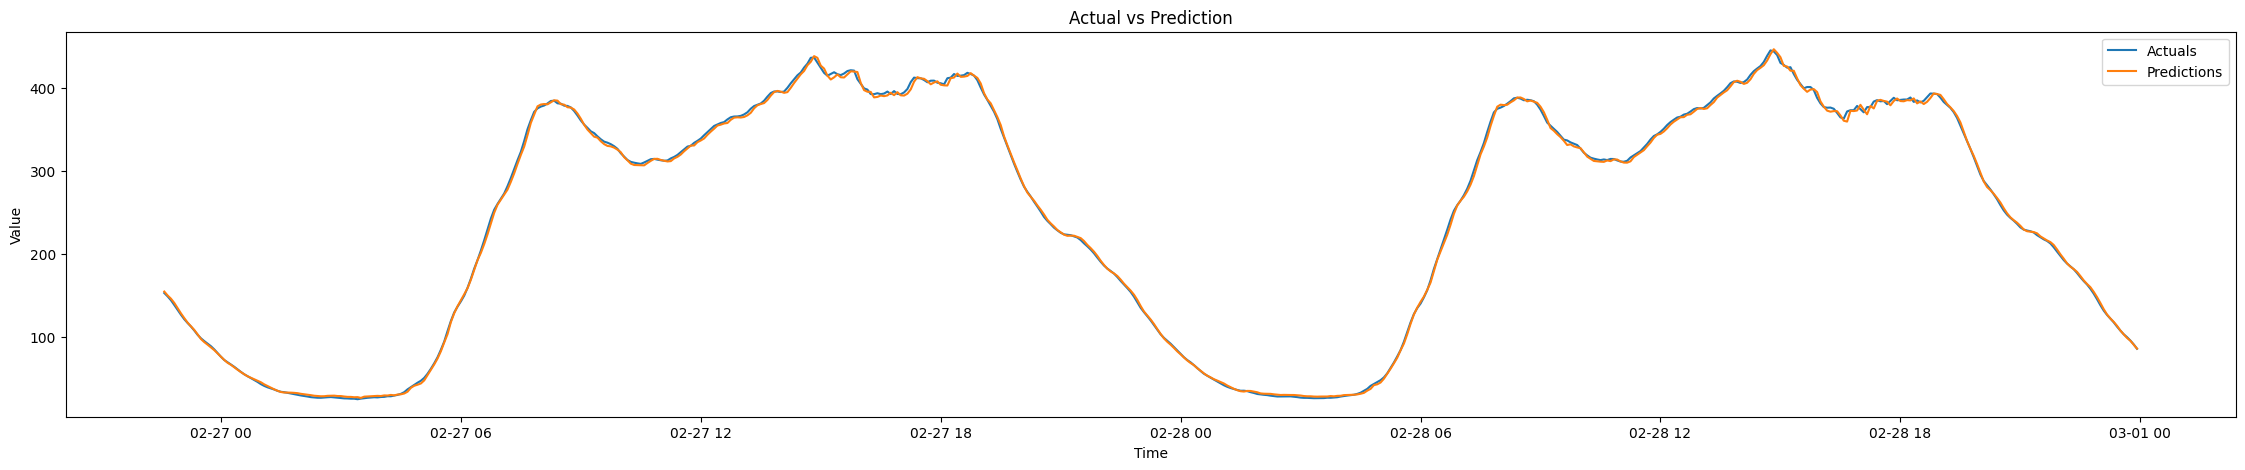

Round 34
RMSE:2.611, MAE:1.985, RMSPE:1.577 % , MAAPE:1.139 %


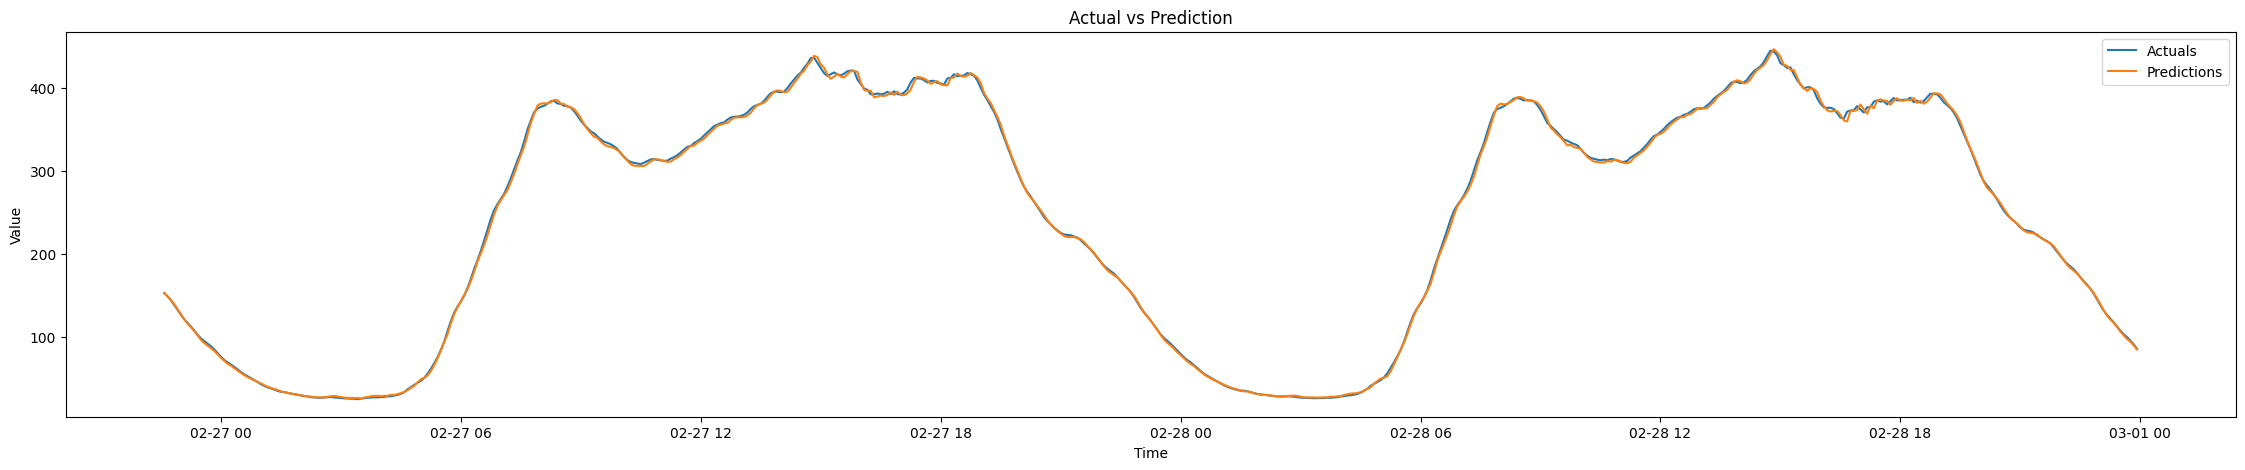

Round 35
RMSE:2.643, MAE:2.063, RMSPE:2.242 % , MAAPE:1.450 %


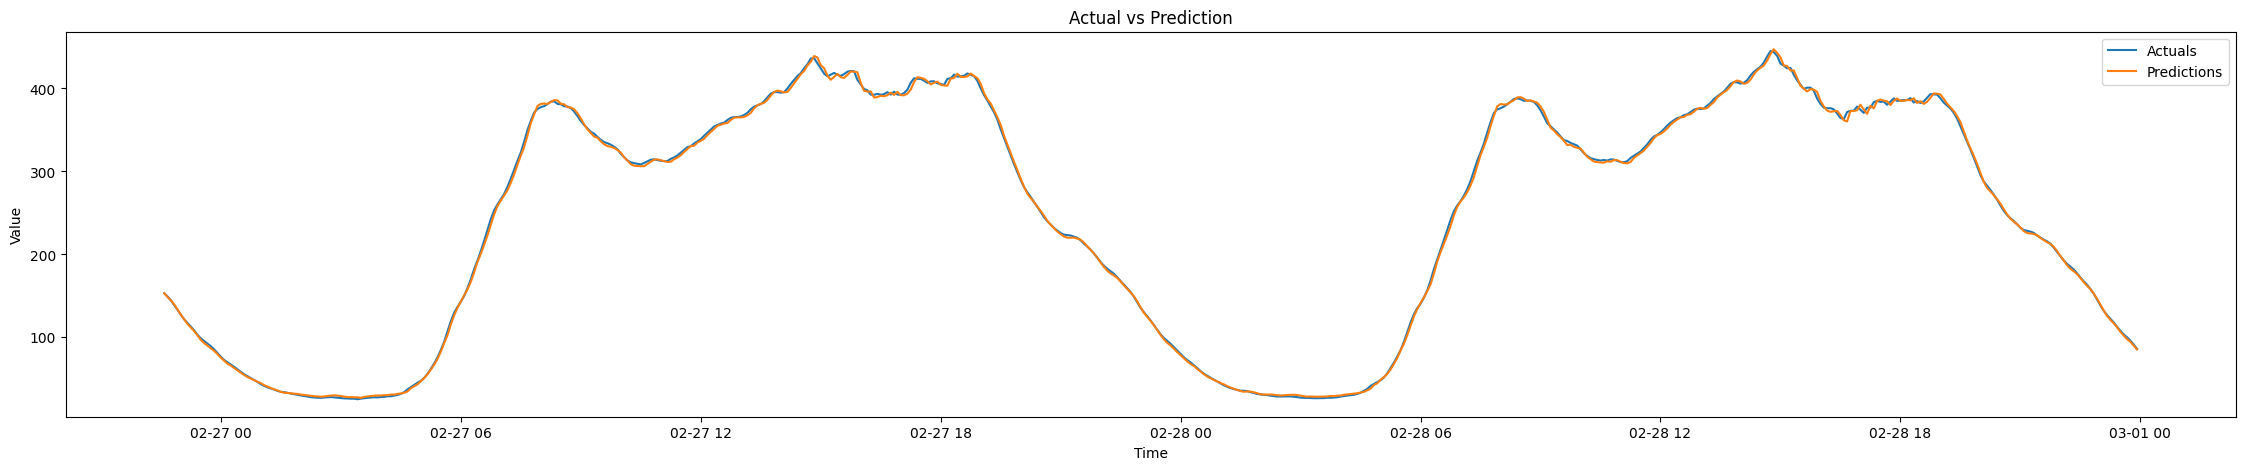

Round 36
RMSE:2.732, MAE:2.159, RMSPE:2.821 % , MAAPE:1.665 %


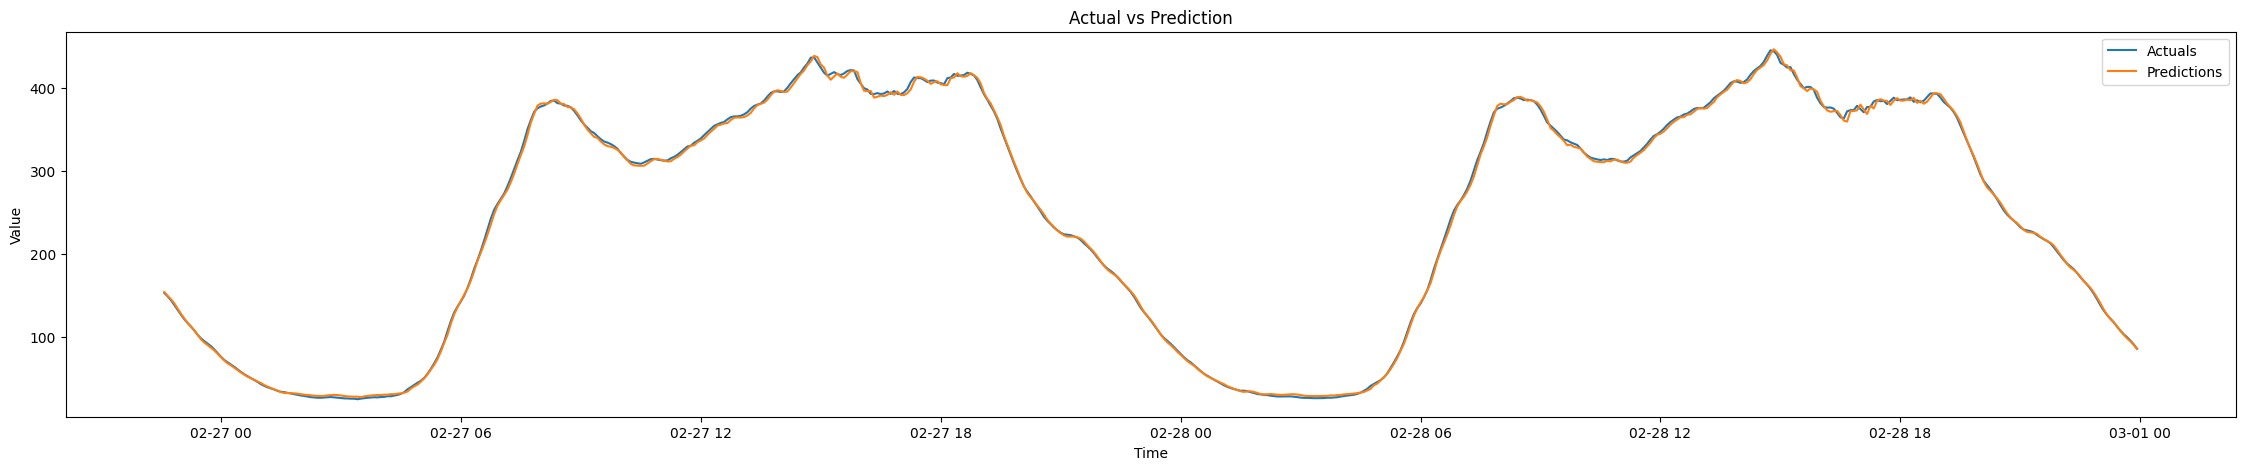

Round 37
RMSE:2.620, MAE:2.036, RMSPE:2.701 % , MAAPE:1.566 %


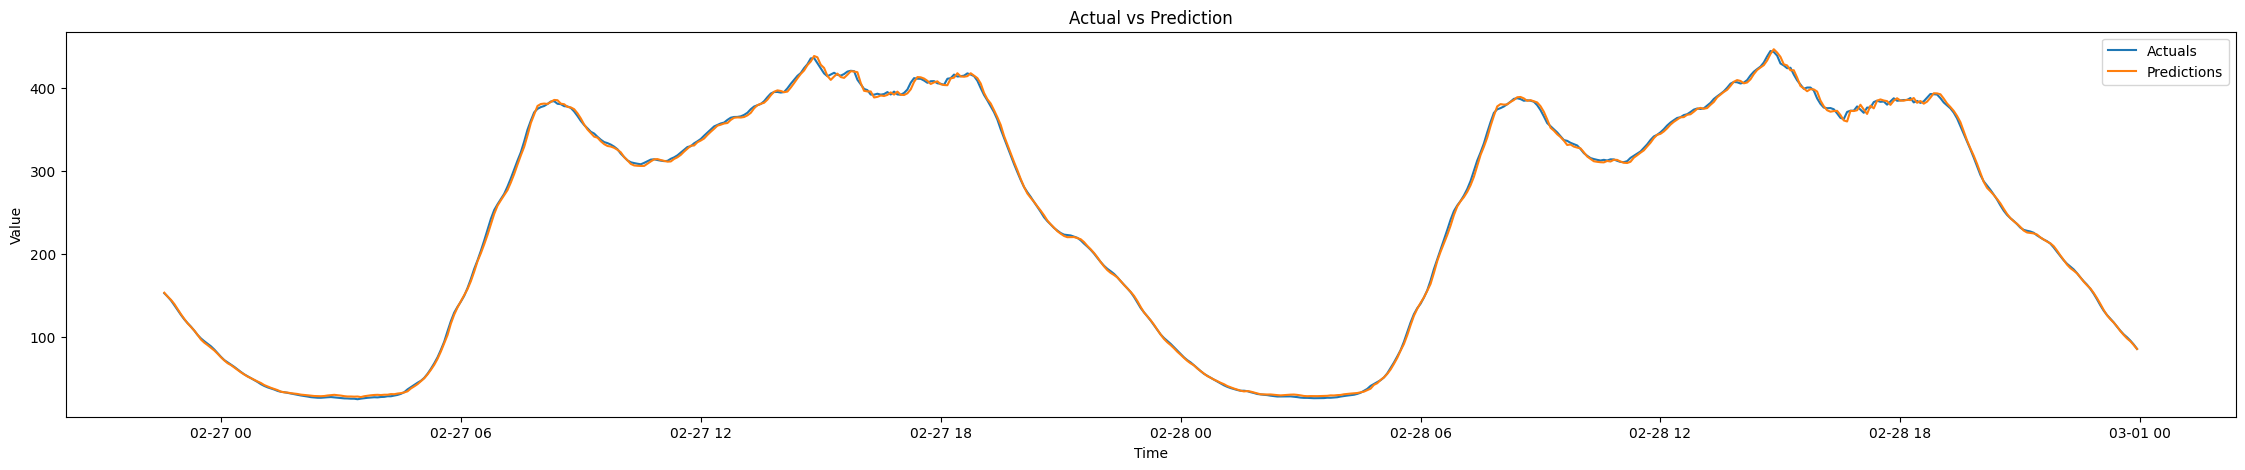

Round 38
RMSE:2.757, MAE:2.185, RMSPE:2.720 % , MAAPE:1.652 %


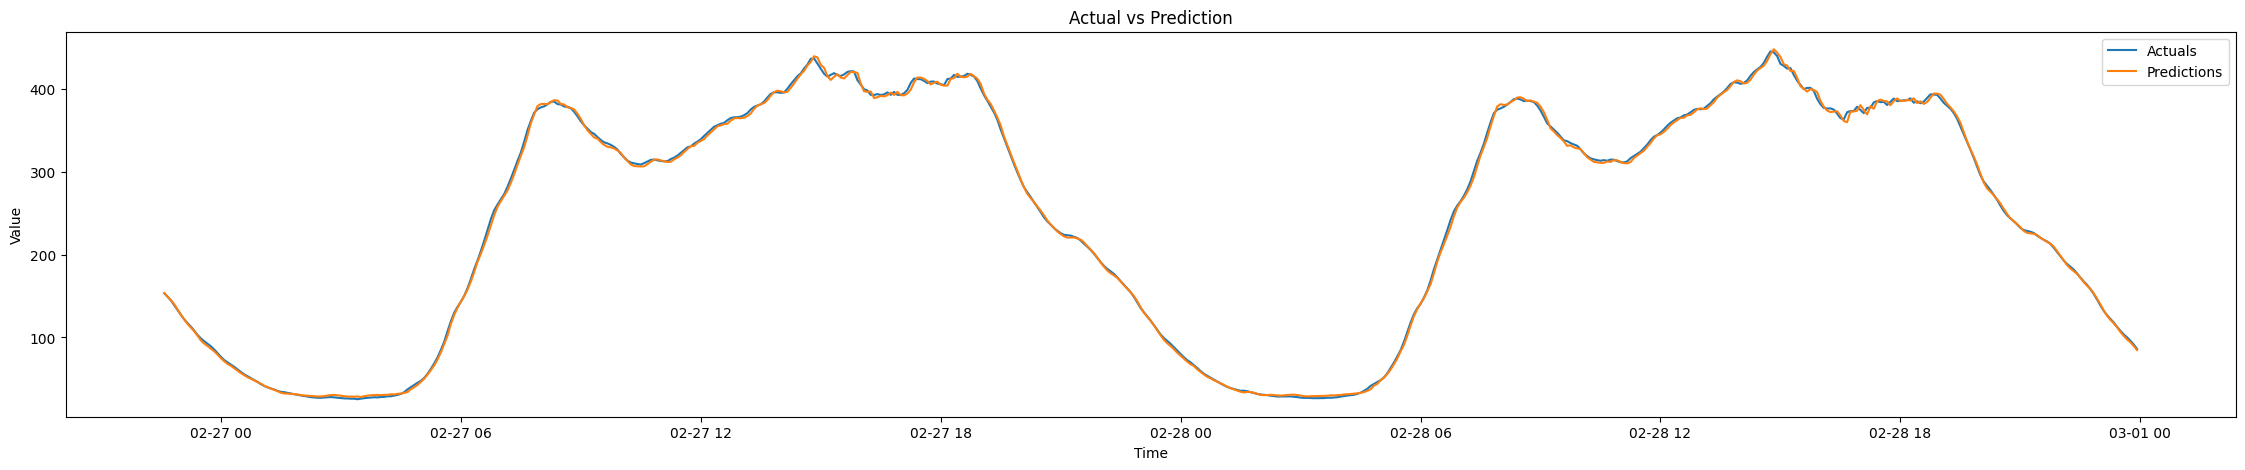

Round 39
RMSE:2.707, MAE:2.146, RMSPE:3.378 % , MAAPE:1.827 %


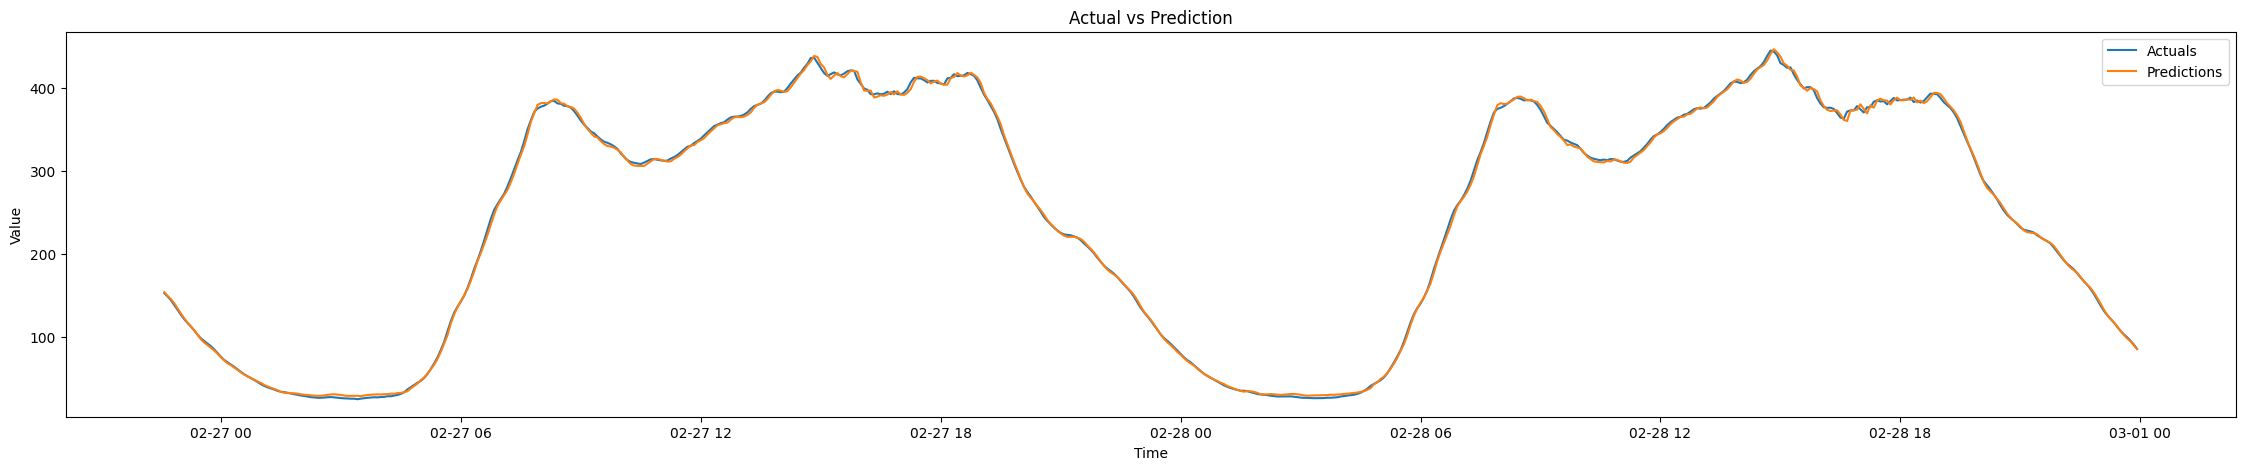

Round 40
RMSE:2.598, MAE:1.906, RMSPE:1.397 % , MAAPE:1.021 %


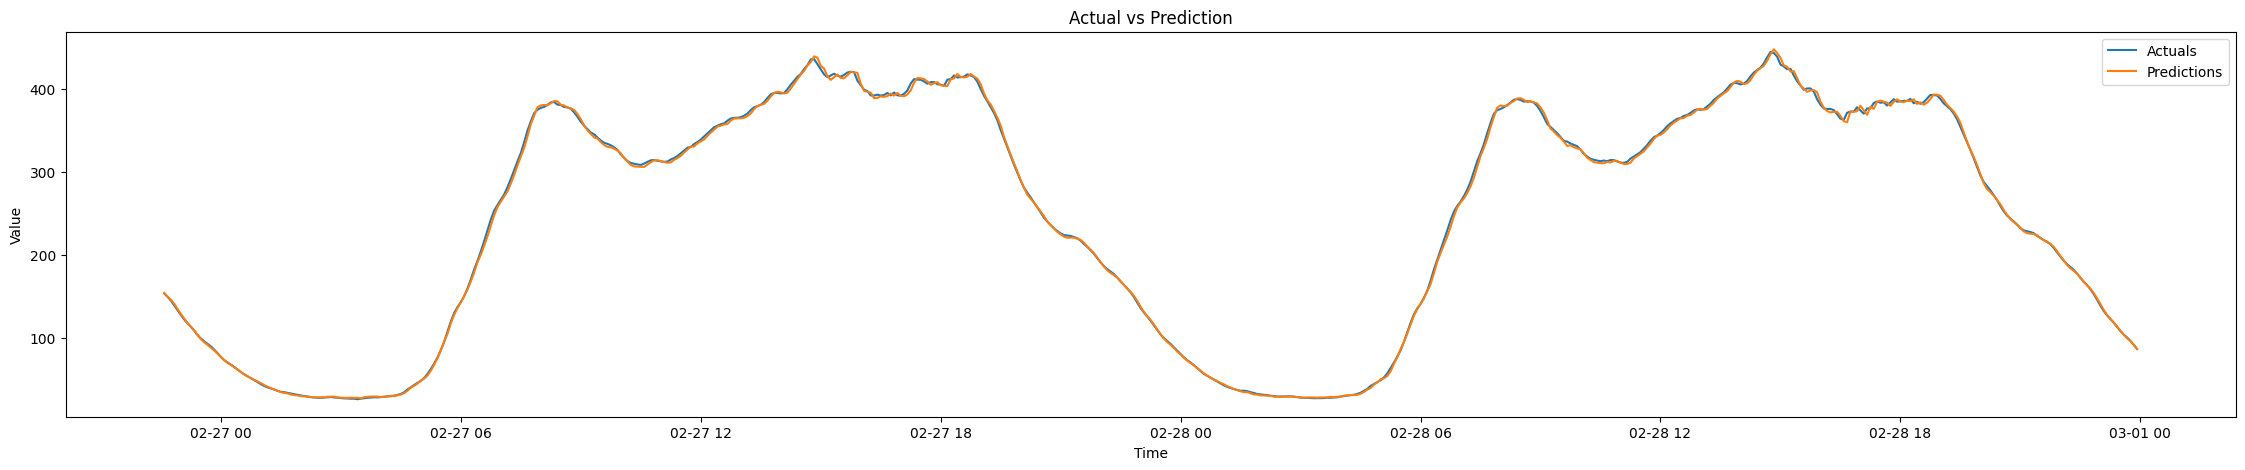

Round 41
RMSE:2.645, MAE:1.985, RMSPE:1.499 % , MAAPE:1.083 %


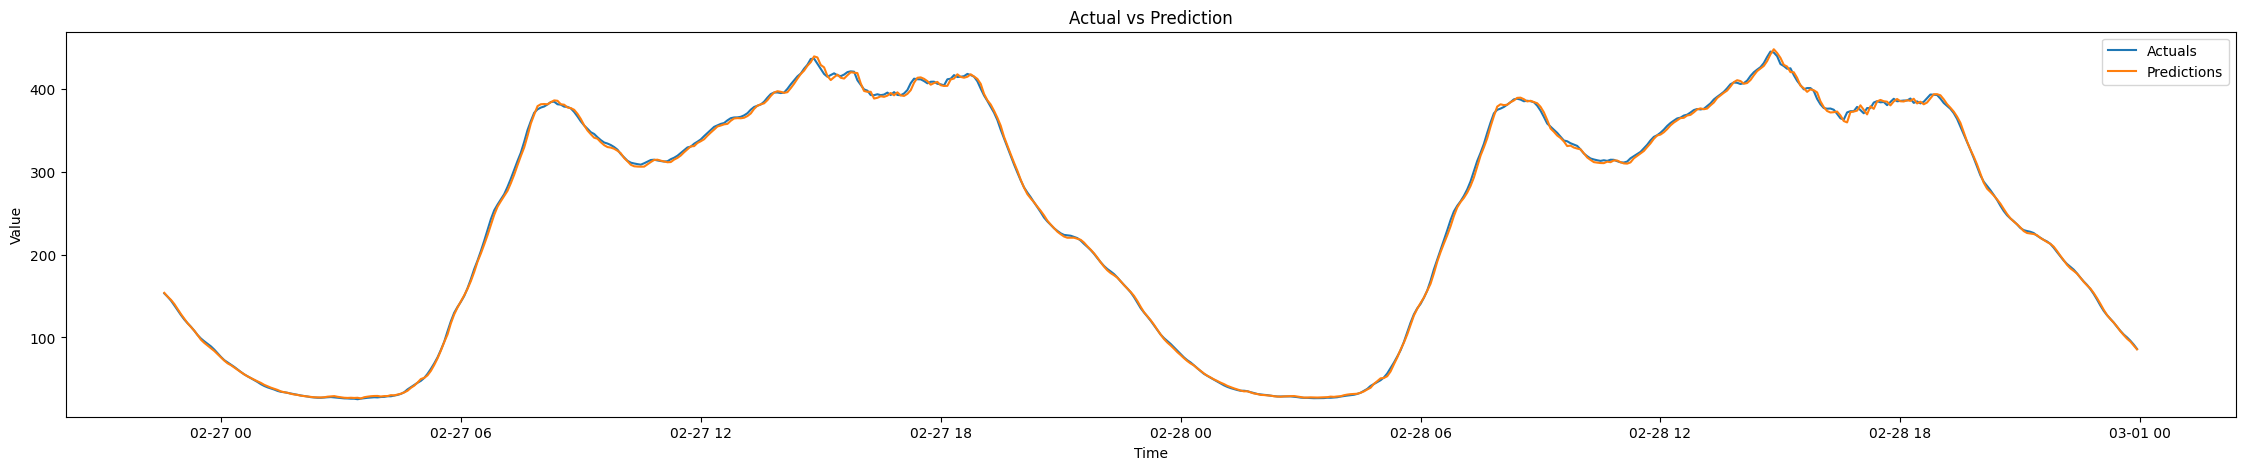

Round 42
RMSE:2.634, MAE:1.976, RMSPE:1.404 % , MAAPE:1.042 %


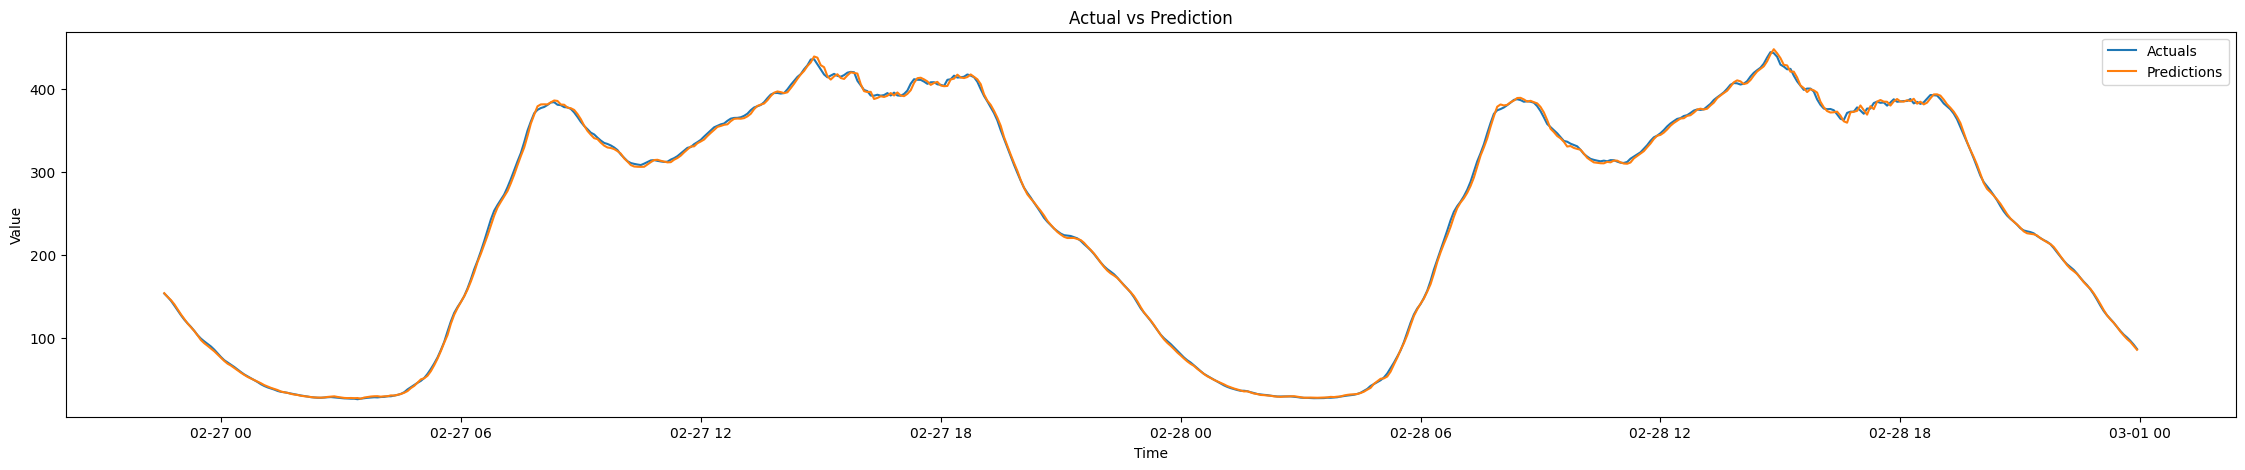

Round 43
RMSE:2.732, MAE:2.065, RMSPE:1.447 % , MAAPE:1.094 %


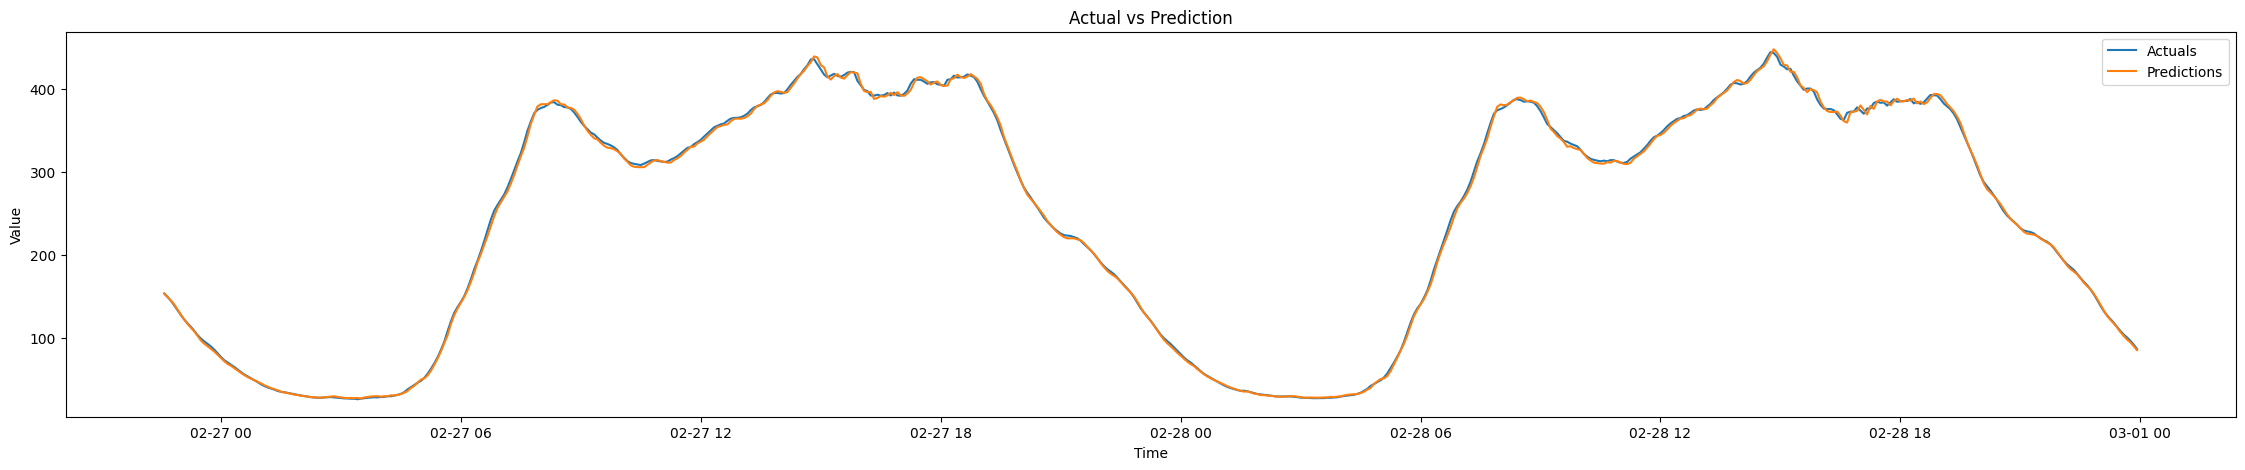

Round 44
RMSE:2.729, MAE:2.104, RMSPE:1.787 % , MAAPE:1.268 %


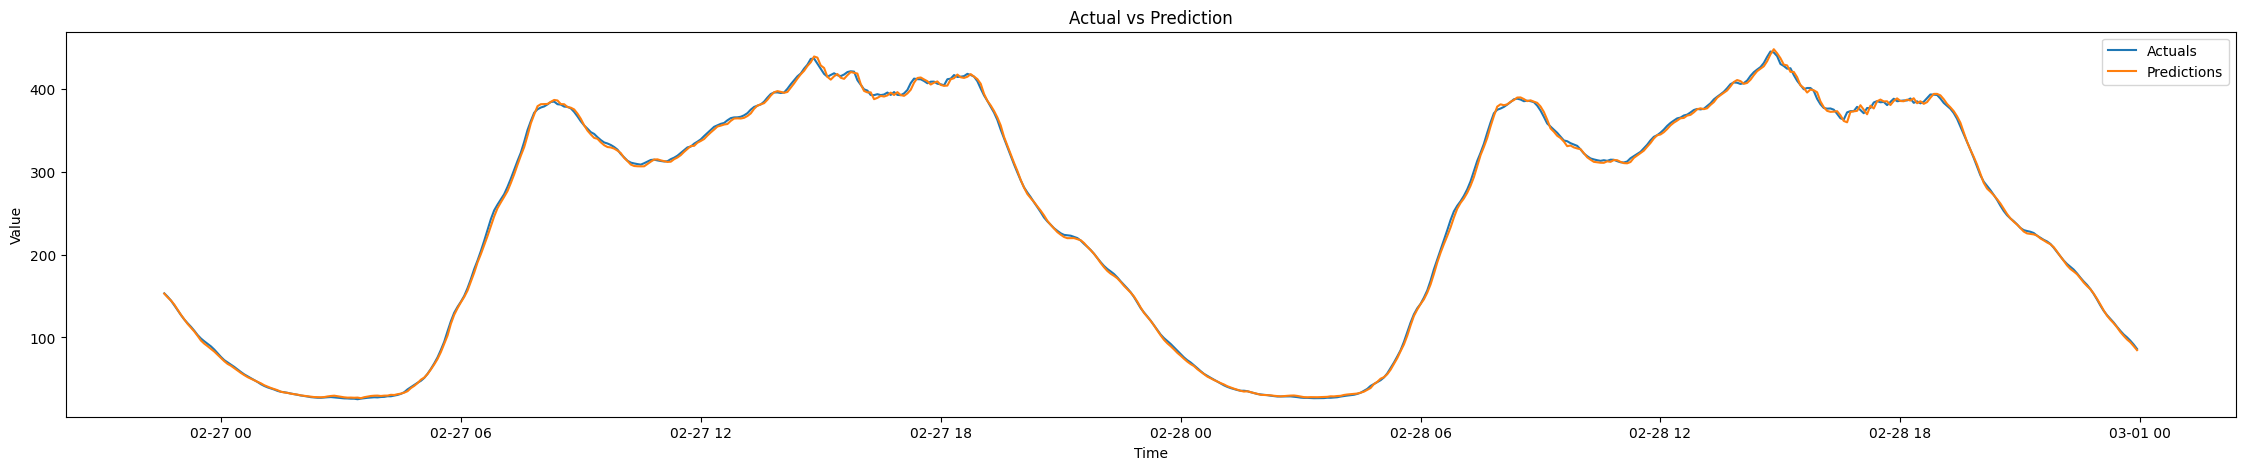

Round 45
RMSE:2.793, MAE:2.184, RMSPE:2.691 % , MAAPE:1.616 %


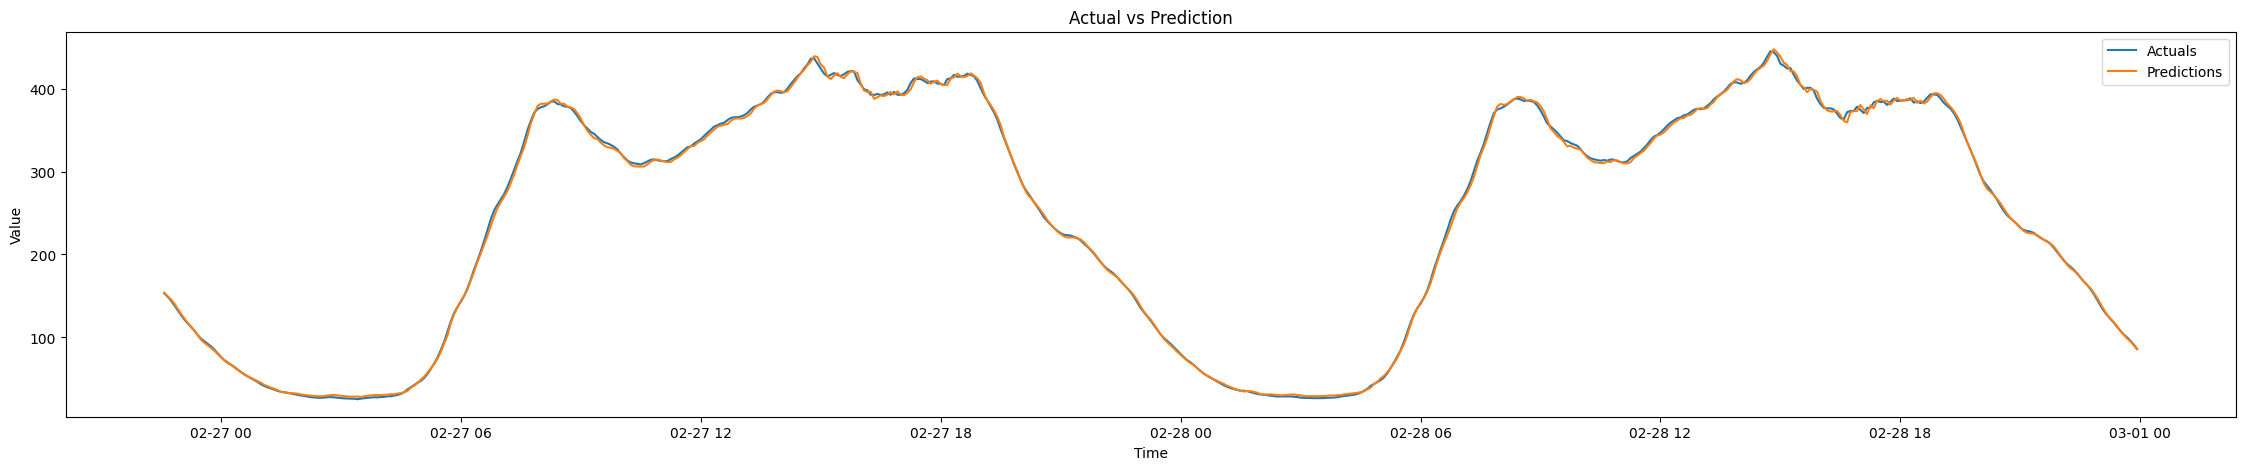

Round 46
RMSE:2.567, MAE:1.893, RMSPE:1.418 % , MAAPE:1.028 %


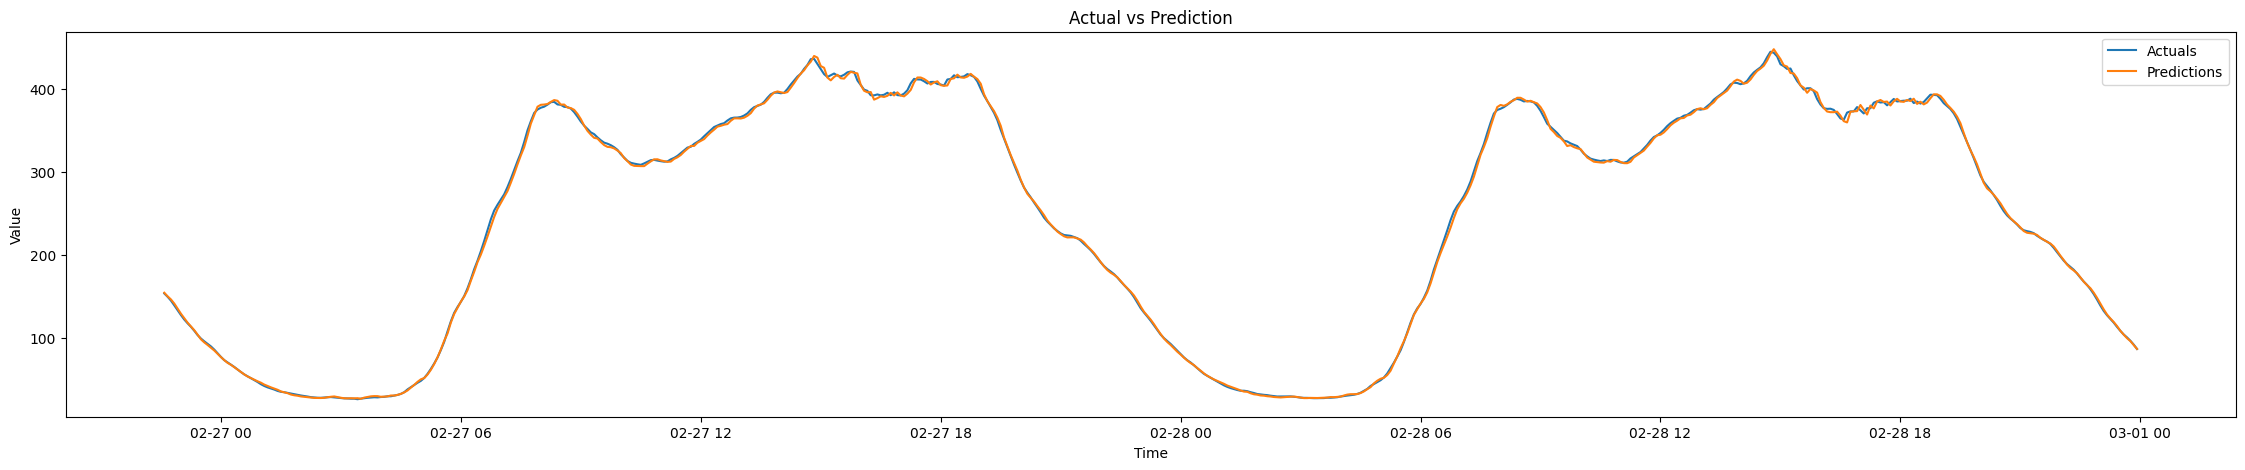

Round 47
RMSE:2.635, MAE:1.969, RMSPE:1.553 % , MAAPE:1.101 %


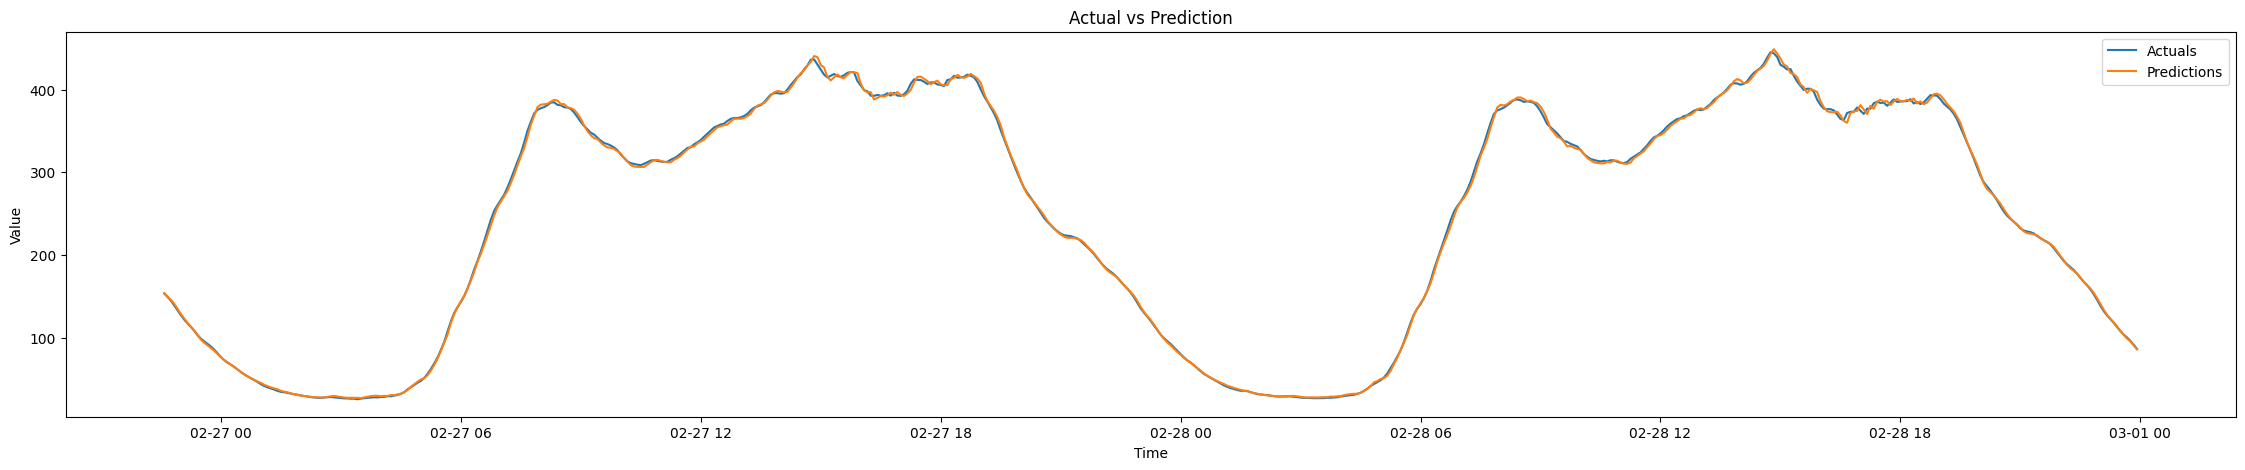

Round 48
RMSE:2.590, MAE:1.925, RMSPE:1.569 % , MAAPE:1.108 %


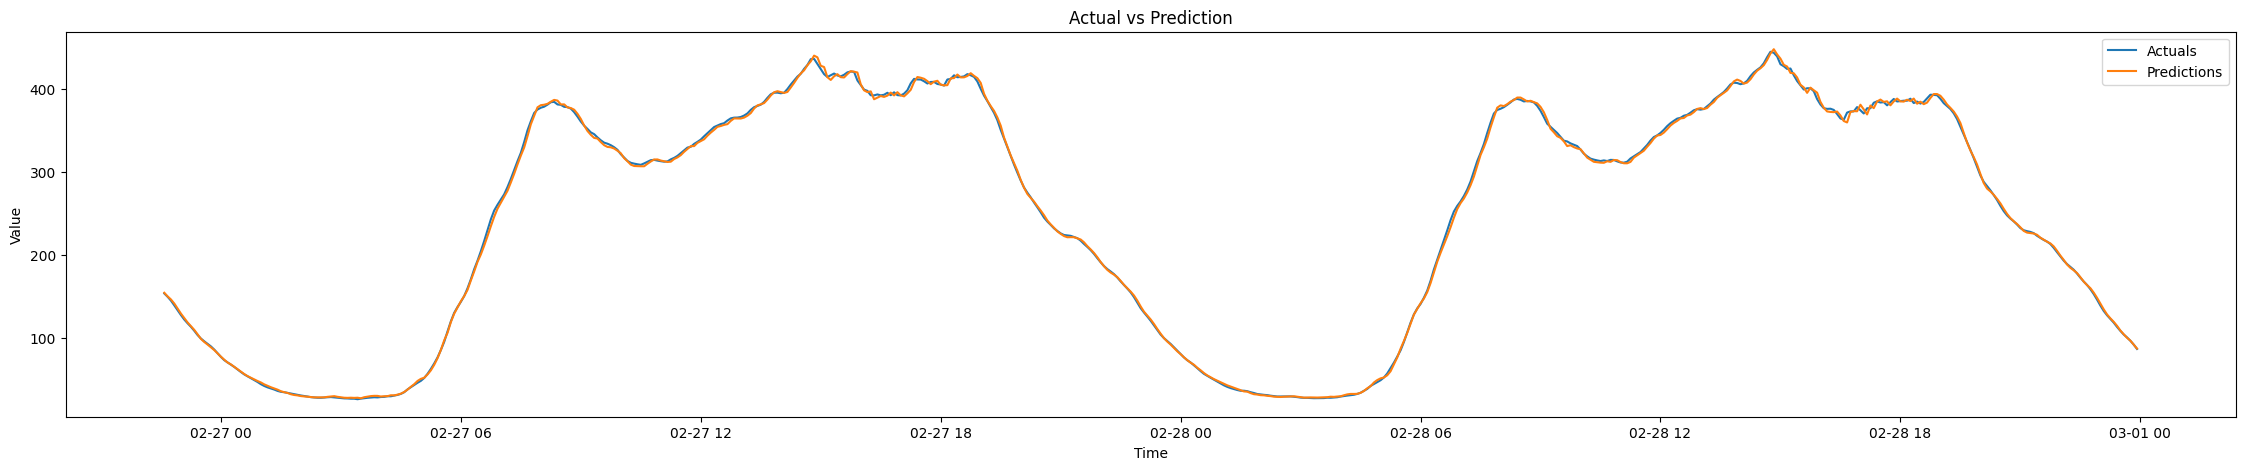

Round 49
RMSE:2.696, MAE:2.092, RMSPE:2.205 % , MAAPE:1.434 %


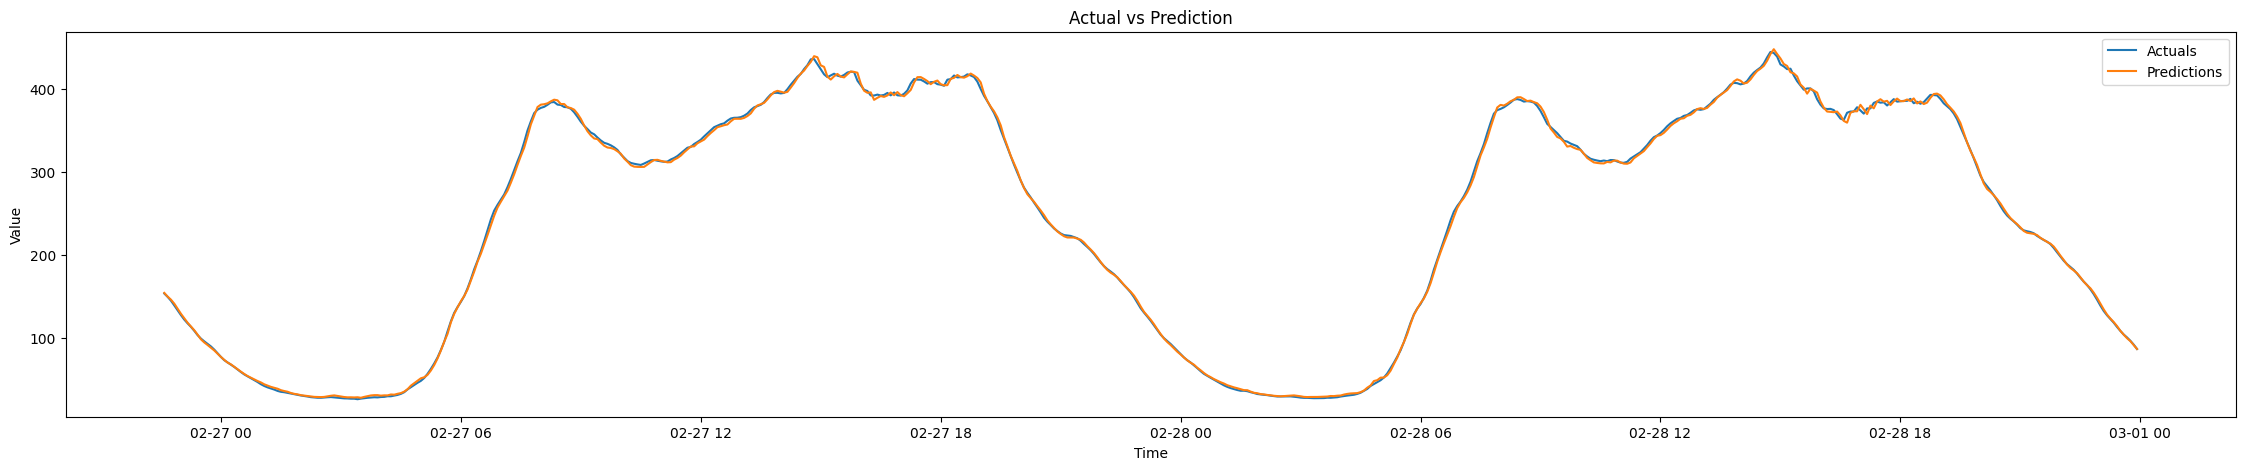

Round 50
RMSE:2.619, MAE:2.007, RMSPE:1.881 % , MAAPE:1.282 %


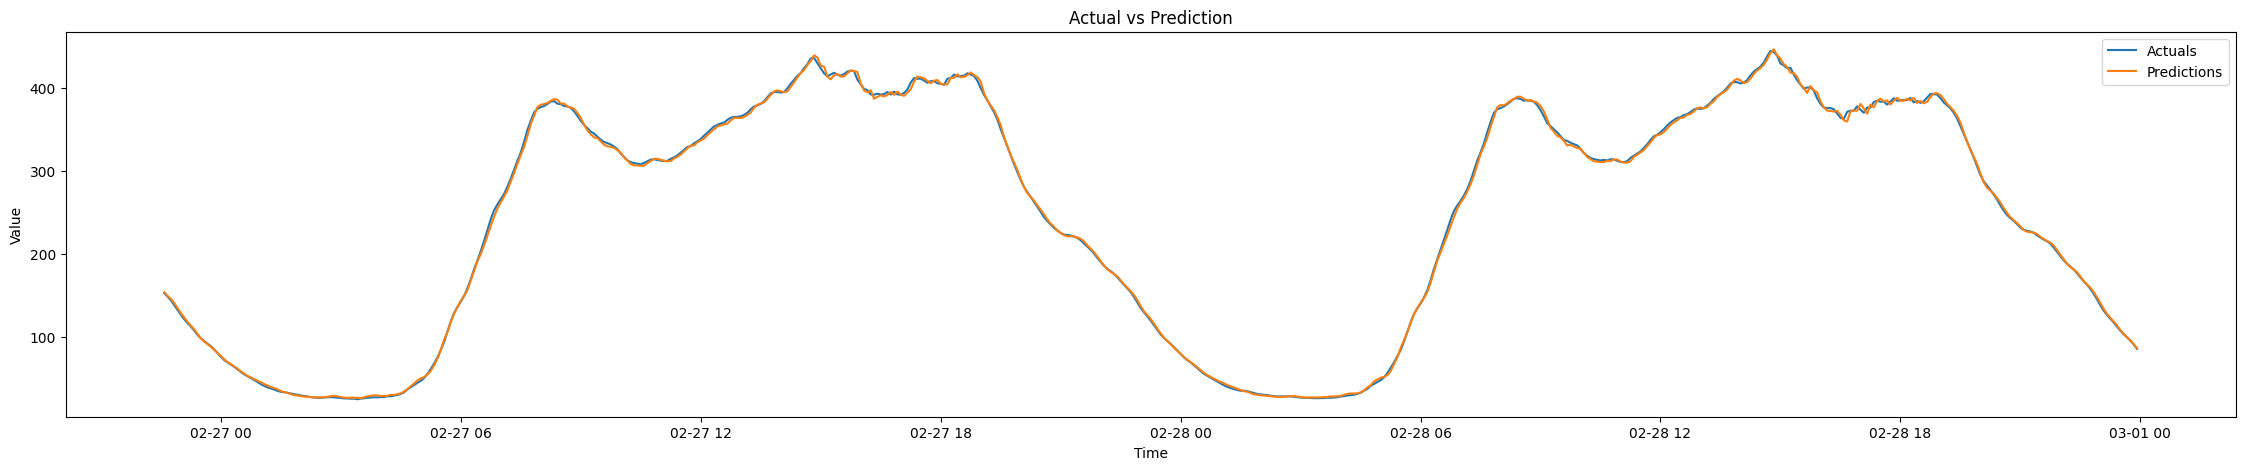

In [65]:
for i in range(3):
    if i==2:
        myplot =True
    else:
        myplot = False
    print('Nodes {} :'.format(i) )
    print("Local")    
    testmodel(localdict[i],i, path= './local{}.pth'.format(i),to_plot= myplot)
    print("NEW Local")   
    #testmodel(localdict[i],i, path= './new_local{}.pth'.format(i),plot=False)
    print("Federated")
    for j in range(1,51):
        print('Round {}'.format(j))
        testmodel(localdict[i],i, path= './model_round_{}.pth'.format(j),to_plot=myplot)
    plt.show()

# Validation Test


In [68]:
for i in range(3):
    print('Nodes {} :'.format(i) )
    print("Local")    
    testmodel(localdict[i],i, path= './local{}.pth'.format(i),testing ='val',to_plot=False)
    #testmodel(localdict[i],i, path= './new_local{}.pth'.format(i),plot=False)
    print("Federated")
    for j in range(1,51):
        print('Round {}'.format(j))
        testmodel(localdict[i],i, path= './model_round_{}.pth'.format(j),testing ='val',to_plot=False)
    plt.show()

Nodes 0 :
Local
RMSE:11.408, MAE:7.752, RMSPE:38.112 % , MAAPE:14.020 %
Federated
Round 1
RMSE:13.810, MAE:10.658, RMSPE:177.326 % , MAAPE:22.673 %
Round 2
RMSE:11.949, MAE:8.742, RMSPE:72.236 % , MAAPE:18.071 %
Round 3
RMSE:11.688, MAE:8.359, RMSPE:76.804 % , MAAPE:17.850 %
Round 4
RMSE:11.864, MAE:8.631, RMSPE:95.242 % , MAAPE:19.276 %
Round 5
RMSE:11.722, MAE:8.408, RMSPE:76.133 % , MAAPE:18.223 %
Round 6
RMSE:11.940, MAE:8.643, RMSPE:97.733 % , MAAPE:19.200 %
Round 7
RMSE:11.850, MAE:8.590, RMSPE:92.074 % , MAAPE:19.209 %
Round 8
RMSE:11.773, MAE:8.473, RMSPE:81.727 % , MAAPE:18.683 %
Round 9
RMSE:11.573, MAE:8.182, RMSPE:62.393 % , MAAPE:17.482 %
Round 10
RMSE:11.571, MAE:8.059, RMSPE:53.630 % , MAAPE:16.293 %
Round 11
RMSE:11.617, MAE:8.265, RMSPE:63.357 % , MAAPE:17.836 %
Round 12
RMSE:11.511, MAE:7.990, RMSPE:45.501 % , MAAPE:15.740 %
Round 13
RMSE:11.607, MAE:8.238, RMSPE:63.479 % , MAAPE:17.491 %
Round 14
RMSE:11.564, MAE:8.251, RMSPE:62.103 % , MAAPE:17.508 %
Round 15
RMSE:1